In [1]:
import os
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tensorboardX import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt



from MnistNet import MnistNet

In [2]:
NUM_EPOCHS = 10
BATCH_SIZE = 128
MOMENTUM = 0.9
LR_DECAY = 0.0005
LR_INIT = 0.01
IMAGE_DIM = 28
NUM_CLASSES = 10
DEVICE_IDS = [0, 1, 2, 3]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# print the seed value
# seed = torch.initial_seed()
# print('Used seed : {}'.format(seed))

In [4]:
mnistnet = MnistNet(num_classes=NUM_CLASSES).to(device)
mnistnet = torch.nn.parallel.DataParallel(mnistnet, device_ids=DEVICE_IDS)
print(mnistnet)
print('MnistNet created')

DataParallel(
  (module): MnistNet(
    (net): Sequential(
      (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(2, 2))
      (1): ReLU()
      (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (5): ReLU()
      (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
      (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU()
      (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU()
      (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_features=256, out_features=4096, bias=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace

In [5]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y = y.astype(int)

/Users/megame/opt/anaconda3/envs/mnist_nn/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [6]:
print(X.shape)
X = X.reshape(X.shape[0], 1, 28, 28)
print(X.shape)

(70000, 784)
(70000, 1, 28, 28)


In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
train_dataset = TensorDataset(torch.from_numpy(X_train).float(),
                              torch.from_numpy(y_train).long())
train_loader = DataLoader(train_dataset,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=8,
                          drop_last=True,
                          batch_size=BATCH_SIZE)

test_dataset = TensorDataset(torch.from_numpy(X_test).float(),
                             torch.from_numpy(y_test).long())
test_loader = DataLoader(test_dataset,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=8,
                          drop_last=True,
                          batch_size=BATCH_SIZE)

In [8]:
import torch.nn as nn
criterion = nn.CrossEntropyLoss()

In [9]:
def evaluate_model(nn_model):
    nn_model.eval()
    with torch.no_grad():
        correct_out = 0
        total_out = 0
        for pics, lbls in test_loader:
            out = nn_model(pics)
            pred = torch.argmax(out, dim=1)
            total_out += lbls.shape[0]
            correct_out += (pred == lbls).sum().item()

    loss_current = criterion(out, lbls)
    return correct_out / total_out, loss_current

In [10]:
# create optimizer
# the one that WORKS
optimizer = optim.Adam(params=mnistnet.parameters(), lr=0.0001)
### BELOW is the setting proposed by the original paper - which doesn't train....
# optimizer = optim.SGD(
#     params=alexnet.parameters(),
#     lr=LR_INIT,
#     momentum=MOMENTUM,
#     weight_decay=LR_DECAY)
print('Optimizer created')

Optimizer created


In [11]:
# multiply LR by 1 / 10 after every 30 epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
print('LR Scheduler created')

accuracy_test_stat = []
accuracy_train_stat = []
loss_test_stat = []
loss_train_stat = []

# start training!!
print('Starting training...')
total_steps = 1
for epoch in range(NUM_EPOCHS):
    epoch_tr_accuracy = 0
    epoch_tr_loss = 0

    lr_scheduler.step()
    for imgs, classes in tqdm(train_loader):
        imgs, classes = imgs.to(device), classes.to(device)

        # calculate the loss
        output = mnistnet(imgs)
        loss = F.cross_entropy(output, classes)

        # update the parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # log the information and add to tensorboard
        if total_steps % 10 == 0:
            with torch.no_grad():
                predictions = torch.argmax(output, dim=1)
                accuracy = (predictions == classes).sum() / len(predictions)

                epoch_tr_accuracy = accuracy.item()
                epoch_tr_loss = loss.item()

                print('Epoch: {} \tStep: {} \tLoss: {:.4f} \tAcc: {}'
                      .format(epoch + 1, total_steps, loss.item(), epoch_tr_accuracy))



        # print out gradient values and parameter average values
        if total_steps % 100 == 0:
            with torch.no_grad():
                # print and save the grad of the parameters
                # also print and save parameter values
                print('*' * 10)
                for name, parameter in mnistnet.named_parameters():
                    if parameter.grad is not None:
                        avg_grad = torch.mean(parameter.grad)
                        # TODO: убрать вывод для удобства восприятия
                        print('\t{} - grad_avg: {}'.format(name, avg_grad))
                        # tbwriter.add_scalar('grad_avg/{}'.format(name), avg_grad.item(), total_steps)
                        # tbwriter.add_histogram('grad/{}'.format(name),
                        #                       parameter.grad.cpu().numpy(), total_steps)
                    if parameter.data is not None:
                        avg_weight = torch.mean(parameter.data)
                        # TODO: убрать вывод для удобства восприятия
                        print('\t{} - param_avg: {}'.format(name, avg_weight))
                        # tbwriter.add_histogram('weight/{}'.format(name),
                        #                       parameter.data.cpu().numpy(), total_steps)
                        # tbwriter.add_scalar('weight_avg/{}'.format(name), avg_weight.item(), total_steps)
        total_steps += 1

    # epoch_tr_accuracy /= len(train_loader)
    # epoch_tr_loss /= len(train_loader)

    a, l = evaluate_model(mnistnet)
    accuracy_train_stat.append(epoch_tr_accuracy)
    accuracy_test_stat.append(a)

    loss_train_stat.append(epoch_tr_loss)
    loss_test_stat.append(l)

    print(accuracy_test_stat, accuracy_train_stat, loss_test_stat, loss_train_stat)



LR Scheduler created
Starting training...


/Users/megame/opt/anaconda3/envs/mnist_nn/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  2%|▏         | 10/468 [00:12<07:20,  1.04it/s]

Epoch: 1 	Step: 10 	Loss: 2.2980 	Acc: 0.078125


  4%|▍         | 20/468 [00:21<06:42,  1.11it/s]

Epoch: 1 	Step: 20 	Loss: 2.2852 	Acc: 0.203125


  6%|▋         | 30/468 [00:30<06:41,  1.09it/s]

Epoch: 1 	Step: 30 	Loss: 2.1276 	Acc: 0.2265625


  9%|▊         | 40/468 [00:39<06:27,  1.11it/s]

Epoch: 1 	Step: 40 	Loss: 1.5462 	Acc: 0.4453125


 11%|█         | 50/468 [00:48<06:12,  1.12it/s]

Epoch: 1 	Step: 50 	Loss: 1.2579 	Acc: 0.5546875


 13%|█▎        | 60/468 [00:57<06:04,  1.12it/s]

Epoch: 1 	Step: 60 	Loss: 1.0573 	Acc: 0.625


 15%|█▍        | 70/468 [01:06<06:14,  1.06it/s]

Epoch: 1 	Step: 70 	Loss: 0.8490 	Acc: 0.6796875


 17%|█▋        | 80/468 [01:15<05:45,  1.12it/s]

Epoch: 1 	Step: 80 	Loss: 0.9563 	Acc: 0.671875


 19%|█▉        | 90/468 [01:24<05:55,  1.06it/s]

Epoch: 1 	Step: 90 	Loss: 0.6366 	Acc: 0.78125


 21%|██▏       | 100/468 [01:38<06:16,  1.02s/it]

Epoch: 1 	Step: 100 	Loss: 0.6709 	Acc: 0.796875
**********
	module.net.0.weight - grad_avg: 0.0015289412112906575
	module.net.0.weight - param_avg: 0.000710230553522706
	module.net.0.bias - grad_avg: 2.2034189896658063e-05
	module.net.0.bias - param_avg: 0.0002548446354921907
	module.net.4.weight - grad_avg: -1.2753158671330311e-06
	module.net.4.weight - param_avg: -0.0002305808593519032
	module.net.4.bias - grad_avg: 6.882771685923217e-06
	module.net.4.bias - param_avg: 1.3720060451305471e-05
	module.net.8.weight - grad_avg: -4.8549209168413654e-05
	module.net.8.weight - param_avg: 2.1523321265704e-05
	module.net.8.bias - grad_avg: -2.818197572196368e-05
	module.net.8.bias - param_avg: 0.00017762598872650415
	module.net.10.weight - grad_avg: -6.1214300330902915e-06
	module.net.10.weight - param_avg: 3.8799724279670045e-05
	module.net.10.bias - grad_avg: -1.0959284736600239e-05
	module.net.10.bias - param_avg: 0.00016303930897265673
	module.net.12.weight - grad_avg: 5.3983940233592875

 24%|██▎       | 110/468 [01:47<05:17,  1.13it/s]

Epoch: 1 	Step: 110 	Loss: 0.7166 	Acc: 0.7890625


 26%|██▌       | 120/468 [01:56<04:57,  1.17it/s]

Epoch: 1 	Step: 120 	Loss: 0.5173 	Acc: 0.8515625


 28%|██▊       | 130/468 [02:04<04:41,  1.20it/s]

Epoch: 1 	Step: 130 	Loss: 0.4919 	Acc: 0.8359375


 30%|██▉       | 140/468 [02:12<04:31,  1.21it/s]

Epoch: 1 	Step: 140 	Loss: 0.2509 	Acc: 0.9296875


 32%|███▏      | 150/468 [02:21<04:24,  1.20it/s]

Epoch: 1 	Step: 150 	Loss: 0.4156 	Acc: 0.859375


 34%|███▍      | 160/468 [02:29<04:12,  1.22it/s]

Epoch: 1 	Step: 160 	Loss: 0.4903 	Acc: 0.859375


 36%|███▋      | 170/468 [02:37<04:04,  1.22it/s]

Epoch: 1 	Step: 170 	Loss: 0.4160 	Acc: 0.890625


 38%|███▊      | 180/468 [02:46<04:07,  1.16it/s]

Epoch: 1 	Step: 180 	Loss: 0.2640 	Acc: 0.90625


 41%|████      | 190/468 [02:54<03:50,  1.20it/s]

Epoch: 1 	Step: 190 	Loss: 0.4632 	Acc: 0.890625


 43%|████▎     | 200/468 [03:03<03:45,  1.19it/s]

Epoch: 1 	Step: 200 	Loss: 0.4018 	Acc: 0.8671875
**********
	module.net.0.weight - grad_avg: 0.004026798997074366
	module.net.0.weight - param_avg: 0.000166365469340235
	module.net.0.bias - grad_avg: 3.10160503431689e-05
	module.net.0.bias - param_avg: -0.0006459219730459154
	module.net.4.weight - grad_avg: 5.915959627600387e-05
	module.net.4.weight - param_avg: -0.00035997104714624584
	module.net.4.bias - grad_avg: 1.0696020581235643e-05
	module.net.4.bias - param_avg: -0.00010995854972861707
	module.net.8.weight - grad_avg: 3.741010368685238e-05
	module.net.8.weight - param_avg: 1.635543412703555e-05
	module.net.8.bias - grad_avg: 4.571127283270471e-05
	module.net.8.bias - param_avg: 0.0001180481631308794
	module.net.10.weight - grad_avg: 5.3148021834203973e-05
	module.net.10.weight - param_avg: 3.870980435749516e-05
	module.net.10.bias - grad_avg: 0.000321411615004763
	module.net.10.bias - param_avg: 0.00020390200370457023
	module.net.12.weight - grad_avg: -1.8087379430653527e-05
	

 45%|████▍     | 210/468 [03:11<03:42,  1.16it/s]

Epoch: 1 	Step: 210 	Loss: 0.2765 	Acc: 0.90625


 47%|████▋     | 220/468 [03:20<03:34,  1.15it/s]

Epoch: 1 	Step: 220 	Loss: 0.2703 	Acc: 0.890625


 49%|████▉     | 230/468 [03:29<03:23,  1.17it/s]

Epoch: 1 	Step: 230 	Loss: 0.2040 	Acc: 0.9453125


 51%|█████▏    | 240/468 [03:38<03:21,  1.13it/s]

Epoch: 1 	Step: 240 	Loss: 0.2719 	Acc: 0.921875


 53%|█████▎    | 250/468 [03:46<03:02,  1.20it/s]

Epoch: 1 	Step: 250 	Loss: 0.4061 	Acc: 0.859375


 56%|█████▌    | 260/468 [03:54<02:50,  1.22it/s]

Epoch: 1 	Step: 260 	Loss: 0.1634 	Acc: 0.953125


 58%|█████▊    | 270/468 [04:03<02:44,  1.20it/s]

Epoch: 1 	Step: 270 	Loss: 0.1287 	Acc: 0.953125


 60%|█████▉    | 280/468 [04:11<02:36,  1.20it/s]

Epoch: 1 	Step: 280 	Loss: 0.1605 	Acc: 0.9453125


 62%|██████▏   | 290/468 [04:19<02:26,  1.22it/s]

Epoch: 1 	Step: 290 	Loss: 0.2714 	Acc: 0.9140625


 64%|██████▍   | 300/468 [04:27<02:13,  1.25it/s]

Epoch: 1 	Step: 300 	Loss: 0.2529 	Acc: 0.8984375
**********
	module.net.0.weight - grad_avg: 0.0017575209494680166
	module.net.0.weight - param_avg: -0.00011404108954593539
	module.net.0.bias - grad_avg: 4.601062755682506e-05
	module.net.0.bias - param_avg: -0.001186374225653708
	module.net.4.weight - grad_avg: -4.7358225856442004e-05
	module.net.4.weight - param_avg: -0.0004022629582323134
	module.net.4.bias - grad_avg: -1.0421409569971729e-05
	module.net.4.bias - param_avg: -0.00018179828475695103
	module.net.8.weight - grad_avg: -4.608161543728784e-05
	module.net.8.weight - param_avg: 1.3591906281362753e-05
	module.net.8.bias - grad_avg: -4.93258994538337e-05
	module.net.8.bias - param_avg: 9.361701086163521e-05
	module.net.10.weight - grad_avg: -3.135670704068616e-05
	module.net.10.weight - param_avg: 4.058454214828089e-05
	module.net.10.bias - grad_avg: -0.0002213574043707922
	module.net.10.bias - param_avg: 0.0002591139345895499
	module.net.12.weight - grad_avg: -3.2593422929494

 66%|██████▌   | 310/468 [04:36<02:11,  1.20it/s]

Epoch: 1 	Step: 310 	Loss: 0.2725 	Acc: 0.921875


 68%|██████▊   | 320/468 [04:44<01:58,  1.25it/s]

Epoch: 1 	Step: 320 	Loss: 0.1710 	Acc: 0.9296875


 71%|███████   | 330/468 [04:52<01:49,  1.26it/s]

Epoch: 1 	Step: 330 	Loss: 0.1581 	Acc: 0.9453125


 73%|███████▎  | 340/468 [04:59<01:41,  1.26it/s]

Epoch: 1 	Step: 340 	Loss: 0.1304 	Acc: 0.9375


 75%|███████▍  | 350/468 [05:07<01:33,  1.26it/s]

Epoch: 1 	Step: 350 	Loss: 0.2112 	Acc: 0.921875


 77%|███████▋  | 360/468 [05:15<01:26,  1.26it/s]

Epoch: 1 	Step: 360 	Loss: 0.2855 	Acc: 0.90625


 79%|███████▉  | 370/468 [05:23<01:17,  1.27it/s]

Epoch: 1 	Step: 370 	Loss: 0.1607 	Acc: 0.953125


 81%|████████  | 380/468 [05:31<01:08,  1.29it/s]

Epoch: 1 	Step: 380 	Loss: 0.1640 	Acc: 0.9609375


 83%|████████▎ | 390/468 [05:39<01:01,  1.26it/s]

Epoch: 1 	Step: 390 	Loss: 0.0876 	Acc: 0.96875


 85%|████████▌ | 400/468 [05:47<00:53,  1.27it/s]

Epoch: 1 	Step: 400 	Loss: 0.1038 	Acc: 0.96875
**********
	module.net.0.weight - grad_avg: 0.00034858036087825894
	module.net.0.weight - param_avg: -0.0004661187413148582
	module.net.0.bias - grad_avg: -4.1190792217093986e-06
	module.net.0.bias - param_avg: -0.0018226327374577522
	module.net.4.weight - grad_avg: -1.378612250846345e-05
	module.net.4.weight - param_avg: -0.0005184866022318602
	module.net.4.bias - grad_avg: -1.09117877400422e-06
	module.net.4.bias - param_avg: -0.00029431923758238554
	module.net.8.weight - grad_avg: -2.898801540140994e-06
	module.net.8.weight - param_avg: 9.53768721956294e-06
	module.net.8.bias - grad_avg: -1.4720535546075553e-06
	module.net.8.bias - param_avg: 6.685694825137034e-05
	module.net.10.weight - grad_avg: -3.6843134694208857e-06
	module.net.10.weight - param_avg: 4.0479259041603655e-05
	module.net.10.bias - grad_avg: -2.584443245723378e-05
	module.net.10.bias - param_avg: 0.00029023666866123676
	module.net.12.weight - grad_avg: 8.8783435785444

 88%|████████▊ | 410/468 [05:55<00:45,  1.26it/s]

Epoch: 1 	Step: 410 	Loss: 0.2653 	Acc: 0.9296875


 90%|████████▉ | 420/468 [06:03<00:37,  1.27it/s]

Epoch: 1 	Step: 420 	Loss: 0.1877 	Acc: 0.921875


 92%|█████████▏| 430/468 [06:11<00:29,  1.28it/s]

Epoch: 1 	Step: 430 	Loss: 0.1253 	Acc: 0.9453125


 94%|█████████▍| 440/468 [06:18<00:21,  1.28it/s]

Epoch: 1 	Step: 440 	Loss: 0.1308 	Acc: 0.96875


 96%|█████████▌| 450/468 [06:26<00:14,  1.27it/s]

Epoch: 1 	Step: 450 	Loss: 0.1545 	Acc: 0.9453125


 98%|█████████▊| 460/468 [06:34<00:06,  1.24it/s]

Epoch: 1 	Step: 460 	Loss: 0.0672 	Acc: 0.96875


100%|██████████| 468/468 [06:41<00:00,  1.16it/s]


[0.9633413461538461] [0.96875] [tensor(0.1371)] [0.06721928715705872]


  0%|          | 2/468 [00:03<11:46,  1.52s/it]

Epoch: 2 	Step: 470 	Loss: 0.0575 	Acc: 0.9765625


  3%|▎         | 12/468 [00:11<06:00,  1.27it/s]

Epoch: 2 	Step: 480 	Loss: 0.0714 	Acc: 0.96875


  5%|▍         | 22/468 [00:18<05:47,  1.29it/s]

Epoch: 2 	Step: 490 	Loss: 0.0943 	Acc: 0.96875


  7%|▋         | 32/468 [00:26<05:37,  1.29it/s]

Epoch: 2 	Step: 500 	Loss: 0.0354 	Acc: 0.9921875
**********
	module.net.0.weight - grad_avg: -0.0016985803376883268
	module.net.0.weight - param_avg: -0.0005780042847618461
	module.net.0.bias - grad_avg: -2.3096783479559235e-05
	module.net.0.bias - param_avg: -0.002158294664695859
	module.net.4.weight - grad_avg: 2.1940060833003372e-05
	module.net.4.weight - param_avg: -0.0005649649538099766
	module.net.4.bias - grad_avg: 4.211293344269507e-06
	module.net.4.bias - param_avg: -0.0003207090776413679
	module.net.8.weight - grad_avg: -2.1763105451100273e-06
	module.net.8.weight - param_avg: 6.526766810566187e-06
	module.net.8.bias - grad_avg: -5.490403509611497e-06
	module.net.8.bias - param_avg: 5.951073762844317e-05
	module.net.10.weight - grad_avg: -6.39190830042935e-06
	module.net.10.weight - param_avg: 4.2117102566407993e-05
	module.net.10.bias - grad_avg: -6.395932723535225e-05
	module.net.10.bias - param_avg: 0.00034534523729234934
	module.net.12.weight - grad_avg: 2.03990430236444

  9%|▉         | 42/468 [00:35<05:42,  1.25it/s]

Epoch: 2 	Step: 510 	Loss: 0.0497 	Acc: 0.984375


 11%|█         | 52/468 [00:43<05:26,  1.28it/s]

Epoch: 2 	Step: 520 	Loss: 0.1295 	Acc: 0.953125


 13%|█▎        | 62/468 [00:50<05:23,  1.26it/s]

Epoch: 2 	Step: 530 	Loss: 0.1554 	Acc: 0.96875


 15%|█▌        | 72/468 [00:58<05:11,  1.27it/s]

Epoch: 2 	Step: 540 	Loss: 0.1546 	Acc: 0.953125


 18%|█▊        | 82/468 [01:06<05:02,  1.28it/s]

Epoch: 2 	Step: 550 	Loss: 0.0645 	Acc: 0.9609375


 20%|█▉        | 92/468 [01:14<04:53,  1.28it/s]

Epoch: 2 	Step: 560 	Loss: 0.0929 	Acc: 0.96875


 22%|██▏       | 102/468 [01:22<04:47,  1.27it/s]

Epoch: 2 	Step: 570 	Loss: 0.0760 	Acc: 0.9765625


 24%|██▍       | 112/468 [01:30<04:40,  1.27it/s]

Epoch: 2 	Step: 580 	Loss: 0.1964 	Acc: 0.9375


 26%|██▌       | 122/468 [01:38<04:30,  1.28it/s]

Epoch: 2 	Step: 590 	Loss: 0.0362 	Acc: 0.9921875


 28%|██▊       | 132/468 [01:46<04:28,  1.25it/s]

Epoch: 2 	Step: 600 	Loss: 0.1267 	Acc: 0.9609375
**********
	module.net.0.weight - grad_avg: 0.0012079236330464482
	module.net.0.weight - param_avg: -0.0007135325577110052
	module.net.0.bias - grad_avg: 3.267121792305261e-05
	module.net.0.bias - param_avg: -0.002509909449145198
	module.net.4.weight - grad_avg: -3.917101275874302e-05
	module.net.4.weight - param_avg: -0.0006097309524193406
	module.net.4.bias - grad_avg: -8.707237611815799e-06
	module.net.4.bias - param_avg: -0.00036675360752269626
	module.net.8.weight - grad_avg: -6.509340437332867e-06
	module.net.8.weight - param_avg: 4.910892130283173e-06
	module.net.8.bias - grad_avg: -2.0604400560841896e-05
	module.net.8.bias - param_avg: 5.815239273943007e-05
	module.net.10.weight - grad_avg: 6.5723647821869235e-06
	module.net.10.weight - param_avg: 4.337125938036479e-05
	module.net.10.bias - grad_avg: 5.487900853040628e-05
	module.net.10.bias - param_avg: 0.0003770735638681799
	module.net.12.weight - grad_avg: 1.3706185200135224e

 30%|███       | 142/468 [01:54<04:14,  1.28it/s]

Epoch: 2 	Step: 610 	Loss: 0.1317 	Acc: 0.96875


 32%|███▏      | 152/468 [02:01<04:08,  1.27it/s]

Epoch: 2 	Step: 620 	Loss: 0.1259 	Acc: 0.9609375


 35%|███▍      | 162/468 [02:09<04:03,  1.26it/s]

Epoch: 2 	Step: 630 	Loss: 0.1101 	Acc: 0.953125


 37%|███▋      | 172/468 [02:17<03:59,  1.23it/s]

Epoch: 2 	Step: 640 	Loss: 0.0826 	Acc: 0.96875


 39%|███▉      | 182/468 [02:25<03:46,  1.26it/s]

Epoch: 2 	Step: 650 	Loss: 0.1317 	Acc: 0.953125


 41%|████      | 192/468 [02:33<03:36,  1.27it/s]

Epoch: 2 	Step: 660 	Loss: 0.0849 	Acc: 0.96875


 43%|████▎     | 202/468 [02:41<03:30,  1.26it/s]

Epoch: 2 	Step: 670 	Loss: 0.0752 	Acc: 0.9765625


 45%|████▌     | 212/468 [02:49<03:24,  1.25it/s]

Epoch: 2 	Step: 680 	Loss: 0.0367 	Acc: 0.9921875


 47%|████▋     | 222/468 [02:57<03:14,  1.27it/s]

Epoch: 2 	Step: 690 	Loss: 0.0492 	Acc: 0.9921875


 50%|████▉     | 232/468 [03:05<03:07,  1.26it/s]

Epoch: 2 	Step: 700 	Loss: 0.1523 	Acc: 0.953125
**********
	module.net.0.weight - grad_avg: -3.633659798651934e-05
	module.net.0.weight - param_avg: -0.000829174357932061
	module.net.0.bias - grad_avg: 5.628443250316195e-05
	module.net.0.bias - param_avg: -0.002821151167154312
	module.net.4.weight - grad_avg: 0.00011745703523047268
	module.net.4.weight - param_avg: -0.0006487930077128112
	module.net.4.bias - grad_avg: 1.8280052245245315e-05
	module.net.4.bias - param_avg: -0.00040638342034071684
	module.net.8.weight - grad_avg: 4.0858958527678624e-05
	module.net.8.weight - param_avg: 2.603147322588484e-06
	module.net.8.bias - grad_avg: 9.175563900498673e-05
	module.net.8.bias - param_avg: 4.4522719690576196e-05
	module.net.10.weight - grad_avg: 3.847178959404118e-06
	module.net.10.weight - param_avg: 4.441426062840037e-05
	module.net.10.bias - grad_avg: 7.21648902981542e-05
	module.net.10.bias - param_avg: 0.0004097706696484238
	module.net.12.weight - grad_avg: -6.120871148596052e-06


 52%|█████▏    | 242/468 [03:13<02:57,  1.27it/s]

Epoch: 2 	Step: 710 	Loss: 0.1449 	Acc: 0.9609375


 54%|█████▍    | 252/468 [03:21<02:52,  1.25it/s]

Epoch: 2 	Step: 720 	Loss: 0.0237 	Acc: 0.9921875


 56%|█████▌    | 262/468 [03:29<02:43,  1.26it/s]

Epoch: 2 	Step: 730 	Loss: 0.0588 	Acc: 0.984375


 58%|█████▊    | 272/468 [03:37<02:39,  1.23it/s]

Epoch: 2 	Step: 740 	Loss: 0.0330 	Acc: 0.9921875


 60%|██████    | 282/468 [03:45<02:27,  1.26it/s]

Epoch: 2 	Step: 750 	Loss: 0.1634 	Acc: 0.953125


 62%|██████▏   | 292/468 [03:53<02:19,  1.26it/s]

Epoch: 2 	Step: 760 	Loss: 0.0658 	Acc: 0.984375


 65%|██████▍   | 302/468 [04:01<02:10,  1.27it/s]

Epoch: 2 	Step: 770 	Loss: 0.0855 	Acc: 0.9765625


 67%|██████▋   | 312/468 [04:09<02:11,  1.19it/s]

Epoch: 2 	Step: 780 	Loss: 0.0939 	Acc: 0.9609375


 69%|██████▉   | 322/468 [04:17<01:57,  1.24it/s]

Epoch: 2 	Step: 790 	Loss: 0.0479 	Acc: 0.984375


 71%|███████   | 332/468 [04:25<01:48,  1.26it/s]

Epoch: 2 	Step: 800 	Loss: 0.1072 	Acc: 0.96875
**********
	module.net.0.weight - grad_avg: 0.0023482968099415302
	module.net.0.weight - param_avg: -0.0009649423882365227
	module.net.0.bias - grad_avg: 8.41747078084154e-06
	module.net.0.bias - param_avg: -0.0032501528039574623
	module.net.4.weight - grad_avg: -7.726140029262751e-05
	module.net.4.weight - param_avg: -0.0007159028318710625
	module.net.4.bias - grad_avg: -1.1618822099990211e-05
	module.net.4.bias - param_avg: -0.00048760659410618246
	module.net.8.weight - grad_avg: -1.759564838721417e-05
	module.net.8.weight - param_avg: -3.056957439184771e-06
	module.net.8.bias - grad_avg: -4.420752520672977e-05
	module.net.8.bias - param_avg: -6.990886959101772e-06
	module.net.10.weight - grad_avg: -9.703722753329203e-06
	module.net.10.weight - param_avg: 4.4666598114417866e-05
	module.net.10.bias - grad_avg: -0.00011163023737026379
	module.net.10.bias - param_avg: 0.00042529148049652576
	module.net.12.weight - grad_avg: -4.105279458599

 73%|███████▎  | 342/468 [04:33<01:40,  1.26it/s]

Epoch: 2 	Step: 810 	Loss: 0.1042 	Acc: 0.9765625


 75%|███████▌  | 352/468 [04:41<01:31,  1.26it/s]

Epoch: 2 	Step: 820 	Loss: 0.0936 	Acc: 0.96875


 77%|███████▋  | 362/468 [04:49<01:24,  1.26it/s]

Epoch: 2 	Step: 830 	Loss: 0.1449 	Acc: 0.9609375


 79%|███████▉  | 372/468 [04:57<01:17,  1.24it/s]

Epoch: 2 	Step: 840 	Loss: 0.0615 	Acc: 0.9921875


 82%|████████▏ | 382/468 [05:05<01:08,  1.26it/s]

Epoch: 2 	Step: 850 	Loss: 0.1008 	Acc: 0.96875


 84%|████████▍ | 392/468 [05:13<01:01,  1.23it/s]

Epoch: 2 	Step: 860 	Loss: 0.0465 	Acc: 0.984375


 86%|████████▌ | 402/468 [05:21<00:53,  1.24it/s]

Epoch: 2 	Step: 870 	Loss: 0.0670 	Acc: 0.9765625


 88%|████████▊ | 412/468 [05:30<00:46,  1.20it/s]

Epoch: 2 	Step: 880 	Loss: 0.0433 	Acc: 0.984375


 90%|█████████ | 422/468 [05:38<00:37,  1.23it/s]

Epoch: 2 	Step: 890 	Loss: 0.1896 	Acc: 0.9375


 92%|█████████▏| 432/468 [05:46<00:29,  1.21it/s]

Epoch: 2 	Step: 900 	Loss: 0.1458 	Acc: 0.9453125
**********
	module.net.0.weight - grad_avg: -0.0013048280961811543
	module.net.0.weight - param_avg: -0.0010374287376180291
	module.net.0.bias - grad_avg: -1.5697589333285578e-05
	module.net.0.bias - param_avg: -0.0035103093832731247
	module.net.4.weight - grad_avg: 7.23226330592297e-05
	module.net.4.weight - param_avg: -0.0007672244682908058
	module.net.4.bias - grad_avg: 3.123456917819567e-05
	module.net.4.bias - param_avg: -0.0005428730510175228
	module.net.8.weight - grad_avg: -8.067021326496615e-07
	module.net.8.weight - param_avg: -5.392252205638215e-06
	module.net.8.bias - grad_avg: 1.2443825653463136e-05
	module.net.8.bias - param_avg: -1.279087518923916e-05
	module.net.10.weight - grad_avg: -8.271810656879097e-06
	module.net.10.weight - param_avg: 4.469159466680139e-05
	module.net.10.bias - grad_avg: -9.004564344650134e-05
	module.net.10.bias - param_avg: 0.0004313394892960787
	module.net.12.weight - grad_avg: 4.181839813099941

 94%|█████████▍| 442/468 [05:57<00:28,  1.11s/it]

Epoch: 2 	Step: 910 	Loss: 0.1696 	Acc: 0.953125


 97%|█████████▋| 452/468 [06:08<00:16,  1.01s/it]

Epoch: 2 	Step: 920 	Loss: 0.0678 	Acc: 0.9921875


 99%|█████████▊| 462/468 [06:17<00:05,  1.11it/s]

Epoch: 2 	Step: 930 	Loss: 0.0877 	Acc: 0.96875


100%|██████████| 468/468 [06:23<00:00,  1.22it/s]


[0.9633413461538461, 0.9799679487179487] [0.96875, 0.96875] [tensor(0.1371), tensor(0.0578)] [0.06721928715705872, 0.08769530802965164]


  1%|          | 4/468 [00:05<08:42,  1.13s/it]

Epoch: 3 	Step: 940 	Loss: 0.0546 	Acc: 0.9921875


  3%|▎         | 14/468 [00:13<06:14,  1.21it/s]

Epoch: 3 	Step: 950 	Loss: 0.0226 	Acc: 0.9921875


  5%|▌         | 24/468 [00:21<06:00,  1.23it/s]

Epoch: 3 	Step: 960 	Loss: 0.0303 	Acc: 0.9921875


  7%|▋         | 34/468 [00:30<06:00,  1.20it/s]

Epoch: 3 	Step: 970 	Loss: 0.0238 	Acc: 0.9921875


  9%|▉         | 44/468 [00:39<06:05,  1.16it/s]

Epoch: 3 	Step: 980 	Loss: 0.0607 	Acc: 0.984375


 12%|█▏        | 54/468 [00:47<05:46,  1.19it/s]

Epoch: 3 	Step: 990 	Loss: 0.0381 	Acc: 0.984375


 14%|█▎        | 64/468 [00:57<06:57,  1.03s/it]

Epoch: 3 	Step: 1000 	Loss: 0.0828 	Acc: 0.96875
**********
	module.net.0.weight - grad_avg: -0.002928698668256402
	module.net.0.weight - param_avg: -0.0011243431363254786
	module.net.0.bias - grad_avg: -1.6574800611124374e-05
	module.net.0.bias - param_avg: -0.0037508495151996613
	module.net.4.weight - grad_avg: 7.14590132702142e-05
	module.net.4.weight - param_avg: -0.0007919808267615736
	module.net.4.bias - grad_avg: 1.5111698303371668e-05
	module.net.4.bias - param_avg: -0.0005644013872370124
	module.net.8.weight - grad_avg: 7.38055859983433e-06
	module.net.8.weight - param_avg: -5.2347527343954425e-06
	module.net.8.bias - grad_avg: 1.505580439697951e-05
	module.net.8.bias - param_avg: -1.6474368749186397e-06
	module.net.10.weight - grad_avg: -2.871481228794437e-06
	module.net.10.weight - param_avg: 4.479368726606481e-05
	module.net.10.bias - grad_avg: -4.9594662414165214e-05
	module.net.10.bias - param_avg: 0.0004419432661961764
	module.net.12.weight - grad_avg: 8.636427082819864e

 16%|█▌        | 74/468 [01:06<05:17,  1.24it/s]

Epoch: 3 	Step: 1010 	Loss: 0.1150 	Acc: 0.96875


 18%|█▊        | 84/468 [01:14<05:12,  1.23it/s]

Epoch: 3 	Step: 1020 	Loss: 0.0269 	Acc: 0.9921875


 20%|██        | 94/468 [01:22<04:59,  1.25it/s]

Epoch: 3 	Step: 1030 	Loss: 0.0572 	Acc: 0.96875


 22%|██▏       | 104/468 [01:30<04:51,  1.25it/s]

Epoch: 3 	Step: 1040 	Loss: 0.0716 	Acc: 0.96875


 24%|██▍       | 114/468 [01:38<04:44,  1.25it/s]

Epoch: 3 	Step: 1050 	Loss: 0.0331 	Acc: 0.9921875


 26%|██▋       | 124/468 [01:46<04:34,  1.25it/s]

Epoch: 3 	Step: 1060 	Loss: 0.0334 	Acc: 0.9765625


 29%|██▊       | 134/468 [01:54<04:31,  1.23it/s]

Epoch: 3 	Step: 1070 	Loss: 0.0257 	Acc: 0.9921875


 31%|███       | 144/468 [02:02<04:17,  1.26it/s]

Epoch: 3 	Step: 1080 	Loss: 0.0411 	Acc: 0.984375


 33%|███▎      | 154/468 [02:10<04:10,  1.25it/s]

Epoch: 3 	Step: 1090 	Loss: 0.1181 	Acc: 0.984375


 35%|███▌      | 164/468 [02:18<04:03,  1.25it/s]

Epoch: 3 	Step: 1100 	Loss: 0.0275 	Acc: 0.9921875
**********
	module.net.0.weight - grad_avg: -0.0008019000524654984
	module.net.0.weight - param_avg: -0.0012170019326731563
	module.net.0.bias - grad_avg: -2.1712141460739076e-05
	module.net.0.bias - param_avg: -0.004037025850266218
	module.net.4.weight - grad_avg: -6.713140919600846e-06
	module.net.4.weight - param_avg: -0.0008484756690450013
	module.net.4.bias - grad_avg: 1.8518544493417721e-06
	module.net.4.bias - param_avg: -0.0006437372649088502
	module.net.8.weight - grad_avg: -4.595028258336242e-06
	module.net.8.weight - param_avg: -9.230569048668258e-06
	module.net.8.bias - grad_avg: -8.70621715876041e-06
	module.net.8.bias - param_avg: -5.180963853490539e-05
	module.net.10.weight - grad_avg: -9.9883282018709e-06
	module.net.10.weight - param_avg: 4.393043855088763e-05
	module.net.10.bias - grad_avg: -0.0001338222500635311
	module.net.10.bias - param_avg: 0.0004206757294014096
	module.net.12.weight - grad_avg: -3.70016073247825

 37%|███▋      | 174/468 [02:26<03:54,  1.26it/s]

Epoch: 3 	Step: 1110 	Loss: 0.0252 	Acc: 0.984375


 39%|███▉      | 184/468 [02:34<03:44,  1.26it/s]

Epoch: 3 	Step: 1120 	Loss: 0.0236 	Acc: 1.0


 41%|████▏     | 194/468 [02:42<03:37,  1.26it/s]

Epoch: 3 	Step: 1130 	Loss: 0.0469 	Acc: 0.984375


 44%|████▎     | 204/468 [02:50<03:32,  1.24it/s]

Epoch: 3 	Step: 1140 	Loss: 0.0128 	Acc: 1.0


 46%|████▌     | 214/468 [02:58<03:20,  1.27it/s]

Epoch: 3 	Step: 1150 	Loss: 0.0581 	Acc: 0.984375


 48%|████▊     | 224/468 [03:06<03:18,  1.23it/s]

Epoch: 3 	Step: 1160 	Loss: 0.0377 	Acc: 0.984375


 50%|█████     | 234/468 [03:14<03:05,  1.26it/s]

Epoch: 3 	Step: 1170 	Loss: 0.0527 	Acc: 0.984375


 52%|█████▏    | 244/468 [03:22<02:59,  1.25it/s]

Epoch: 3 	Step: 1180 	Loss: 0.0610 	Acc: 0.96875


 54%|█████▍    | 254/468 [03:30<02:52,  1.24it/s]

Epoch: 3 	Step: 1190 	Loss: 0.0277 	Acc: 0.9921875


 56%|█████▋    | 264/468 [03:38<02:43,  1.25it/s]

Epoch: 3 	Step: 1200 	Loss: 0.0566 	Acc: 0.984375
**********
	module.net.0.weight - grad_avg: -0.0005132768419571221
	module.net.0.weight - param_avg: -0.001316003268584609
	module.net.0.bias - grad_avg: -4.763766992255114e-05
	module.net.0.bias - param_avg: -0.004344590473920107
	module.net.4.weight - grad_avg: -9.539616439724341e-05
	module.net.4.weight - param_avg: -0.0008850862504914403
	module.net.4.bias - grad_avg: -1.7686876162770204e-05
	module.net.4.bias - param_avg: -0.0006913488614372909
	module.net.8.weight - grad_avg: -2.2626925783697516e-05
	module.net.8.weight - param_avg: -1.3373769434110727e-05
	module.net.8.bias - grad_avg: -6.59303113934584e-05
	module.net.8.bias - param_avg: -8.347267430508509e-05
	module.net.10.weight - grad_avg: -1.265584614884574e-06
	module.net.10.weight - param_avg: 4.4219690607860684e-05
	module.net.10.bias - grad_avg: -5.106425305712037e-05
	module.net.10.bias - param_avg: 0.00043146140524186194
	module.net.12.weight - grad_avg: 5.54918422324

 59%|█████▊    | 274/468 [03:47<02:34,  1.25it/s]

Epoch: 3 	Step: 1210 	Loss: 0.0219 	Acc: 0.9921875


 61%|██████    | 284/468 [03:55<02:25,  1.26it/s]

Epoch: 3 	Step: 1220 	Loss: 0.0079 	Acc: 1.0


 63%|██████▎   | 294/468 [04:03<02:19,  1.24it/s]

Epoch: 3 	Step: 1230 	Loss: 0.0272 	Acc: 0.984375


 65%|██████▍   | 304/468 [04:11<02:10,  1.26it/s]

Epoch: 3 	Step: 1240 	Loss: 0.0070 	Acc: 1.0


 67%|██████▋   | 314/468 [04:19<02:04,  1.24it/s]

Epoch: 3 	Step: 1250 	Loss: 0.0372 	Acc: 0.9921875


 69%|██████▉   | 324/468 [04:27<01:55,  1.25it/s]

Epoch: 3 	Step: 1260 	Loss: 0.0972 	Acc: 0.9453125


 71%|███████▏  | 334/468 [04:36<01:54,  1.17it/s]

Epoch: 3 	Step: 1270 	Loss: 0.0053 	Acc: 1.0


 74%|███████▎  | 344/468 [04:44<01:38,  1.26it/s]

Epoch: 3 	Step: 1280 	Loss: 0.1044 	Acc: 0.9765625


 76%|███████▌  | 354/468 [04:52<01:29,  1.27it/s]

Epoch: 3 	Step: 1290 	Loss: 0.0142 	Acc: 0.9921875


 78%|███████▊  | 364/468 [05:00<01:21,  1.27it/s]

Epoch: 3 	Step: 1300 	Loss: 0.0220 	Acc: 0.984375
**********
	module.net.0.weight - grad_avg: -0.002696487819775939
	module.net.0.weight - param_avg: -0.0013601579703390598
	module.net.0.bias - grad_avg: -2.8157914130133577e-05
	module.net.0.bias - param_avg: -0.004516343120485544
	module.net.4.weight - grad_avg: -3.884001853293739e-05
	module.net.4.weight - param_avg: -0.000925728993024677
	module.net.4.bias - grad_avg: -9.479496839048807e-06
	module.net.4.bias - param_avg: -0.0007393144187517464
	module.net.8.weight - grad_avg: -1.9593593606259674e-05
	module.net.8.weight - param_avg: -1.713272649794817e-05
	module.net.8.bias - grad_avg: -5.713103382731788e-05
	module.net.8.bias - param_avg: -0.00012378423707559705
	module.net.10.weight - grad_avg: -1.4011483472131658e-05
	module.net.10.weight - param_avg: 4.454794543562457e-05
	module.net.10.bias - grad_avg: -0.0002215973217971623
	module.net.10.bias - param_avg: 0.00043502403423190117
	module.net.12.weight - grad_avg: -1.9775789041

 80%|███████▉  | 374/468 [05:08<01:13,  1.28it/s]

Epoch: 3 	Step: 1310 	Loss: 0.0531 	Acc: 0.984375


 82%|████████▏ | 384/468 [05:16<01:08,  1.22it/s]

Epoch: 3 	Step: 1320 	Loss: 0.0239 	Acc: 0.9921875


 84%|████████▍ | 394/468 [05:24<01:01,  1.20it/s]

Epoch: 3 	Step: 1330 	Loss: 0.0434 	Acc: 0.984375


 86%|████████▋ | 404/468 [05:33<00:52,  1.22it/s]

Epoch: 3 	Step: 1340 	Loss: 0.0508 	Acc: 0.9765625


 88%|████████▊ | 414/468 [05:41<00:43,  1.25it/s]

Epoch: 3 	Step: 1350 	Loss: 0.0066 	Acc: 1.0


 91%|█████████ | 424/468 [05:49<00:35,  1.25it/s]

Epoch: 3 	Step: 1360 	Loss: 0.1085 	Acc: 0.96875


 93%|█████████▎| 434/468 [05:57<00:27,  1.25it/s]

Epoch: 3 	Step: 1370 	Loss: 0.0355 	Acc: 0.984375


 95%|█████████▍| 444/468 [06:05<00:19,  1.24it/s]

Epoch: 3 	Step: 1380 	Loss: 0.1079 	Acc: 0.953125


 97%|█████████▋| 454/468 [06:13<00:11,  1.22it/s]

Epoch: 3 	Step: 1390 	Loss: 0.0206 	Acc: 1.0


 99%|█████████▉| 464/468 [06:21<00:03,  1.21it/s]

Epoch: 3 	Step: 1400 	Loss: 0.0525 	Acc: 0.984375
**********
	module.net.0.weight - grad_avg: 0.002338380552828312
	module.net.0.weight - param_avg: -0.0014100219123065472
	module.net.0.bias - grad_avg: 5.355500979931094e-05
	module.net.0.bias - param_avg: -0.004817723762243986
	module.net.4.weight - grad_avg: 2.044886969088111e-05
	module.net.4.weight - param_avg: -0.0009621834615245461
	module.net.4.bias - grad_avg: 3.971927071688697e-06
	module.net.4.bias - param_avg: -0.0007862921920605004
	module.net.8.weight - grad_avg: 1.6345955373253673e-05
	module.net.8.weight - param_avg: -1.9315348254167475e-05
	module.net.8.bias - grad_avg: 4.459062256501056e-05
	module.net.8.bias - param_avg: -0.0001357951114187017
	module.net.10.weight - grad_avg: 1.956244588541267e-08
	module.net.10.weight - param_avg: 4.318604987929575e-05
	module.net.10.bias - grad_avg: -1.2134623830206692e-06
	module.net.10.bias - param_avg: 0.00042129959911108017
	module.net.12.weight - grad_avg: -8.094505687950004e-

100%|██████████| 468/468 [06:25<00:00,  1.21it/s]


[0.9633413461538461, 0.9799679487179487, 0.9800681089743589] [0.96875, 0.96875, 0.984375] [tensor(0.1371), tensor(0.0578), tensor(0.1151)] [0.06721928715705872, 0.08769530802965164, 0.052476316690444946]


  1%|▏         | 6/468 [00:06<07:03,  1.09it/s]

Epoch: 4 	Step: 1410 	Loss: 0.0268 	Acc: 0.9921875


  3%|▎         | 16/468 [00:15<06:19,  1.19it/s]

Epoch: 4 	Step: 1420 	Loss: 0.0579 	Acc: 0.9765625


  6%|▌         | 26/468 [00:23<05:58,  1.23it/s]

Epoch: 4 	Step: 1430 	Loss: 0.0732 	Acc: 0.984375


  8%|▊         | 36/468 [00:31<05:58,  1.21it/s]

Epoch: 4 	Step: 1440 	Loss: 0.1337 	Acc: 0.9765625


 10%|▉         | 46/468 [00:39<05:41,  1.24it/s]

Epoch: 4 	Step: 1450 	Loss: 0.0420 	Acc: 0.9921875


 12%|█▏        | 56/468 [00:47<05:32,  1.24it/s]

Epoch: 4 	Step: 1460 	Loss: 0.0540 	Acc: 0.9765625


 14%|█▍        | 66/468 [00:55<05:23,  1.24it/s]

Epoch: 4 	Step: 1470 	Loss: 0.0171 	Acc: 0.9921875


 16%|█▌        | 76/468 [01:03<05:15,  1.24it/s]

Epoch: 4 	Step: 1480 	Loss: 0.0103 	Acc: 1.0


 18%|█▊        | 86/468 [01:12<05:27,  1.17it/s]

Epoch: 4 	Step: 1490 	Loss: 0.0219 	Acc: 0.984375


 21%|██        | 96/468 [01:20<05:06,  1.21it/s]

Epoch: 4 	Step: 1500 	Loss: 0.0207 	Acc: 1.0
**********
	module.net.0.weight - grad_avg: 0.00034135839086957276
	module.net.0.weight - param_avg: -0.0014914075145497918
	module.net.0.bias - grad_avg: -3.5999419196741655e-06
	module.net.0.bias - param_avg: -0.0050948141142725945
	module.net.4.weight - grad_avg: -3.222020313842222e-05
	module.net.4.weight - param_avg: -0.0009829920018091798
	module.net.4.bias - grad_avg: -7.968887985043693e-06
	module.net.4.bias - param_avg: -0.0008031050092540681
	module.net.8.weight - grad_avg: -6.714275059493957e-06
	module.net.8.weight - param_avg: -2.2446107323048636e-05
	module.net.8.bias - grad_avg: -2.3858321583247744e-05
	module.net.8.bias - param_avg: -0.0001553765614517033
	module.net.10.weight - grad_avg: -5.084351869300008e-06
	module.net.10.weight - param_avg: 4.2920040868921205e-05
	module.net.10.bias - grad_avg: -8.447043364867568e-05
	module.net.10.bias - param_avg: 0.0004291974473744631
	module.net.12.weight - grad_avg: -1.4203521914168

 23%|██▎       | 106/468 [01:28<04:52,  1.24it/s]

Epoch: 4 	Step: 1510 	Loss: 0.0461 	Acc: 0.9765625


 25%|██▍       | 116/468 [01:36<04:43,  1.24it/s]

Epoch: 4 	Step: 1520 	Loss: 0.1276 	Acc: 0.9609375


 27%|██▋       | 126/468 [01:44<04:35,  1.24it/s]

Epoch: 4 	Step: 1530 	Loss: 0.0057 	Acc: 1.0


 29%|██▉       | 136/468 [01:52<04:27,  1.24it/s]

Epoch: 4 	Step: 1540 	Loss: 0.0426 	Acc: 0.9921875


 31%|███       | 146/468 [02:00<04:18,  1.24it/s]

Epoch: 4 	Step: 1550 	Loss: 0.0304 	Acc: 0.984375


 33%|███▎      | 156/468 [02:09<04:12,  1.24it/s]

Epoch: 4 	Step: 1560 	Loss: 0.0613 	Acc: 0.984375


 35%|███▌      | 166/468 [02:17<04:07,  1.22it/s]

Epoch: 4 	Step: 1570 	Loss: 0.0571 	Acc: 0.9765625


 38%|███▊      | 176/468 [02:25<04:05,  1.19it/s]

Epoch: 4 	Step: 1580 	Loss: 0.0084 	Acc: 1.0


 40%|███▉      | 186/468 [02:33<03:48,  1.23it/s]

Epoch: 4 	Step: 1590 	Loss: 0.1014 	Acc: 0.96875


 42%|████▏     | 196/468 [02:41<03:40,  1.24it/s]

Epoch: 4 	Step: 1600 	Loss: 0.0161 	Acc: 0.9921875
**********
	module.net.0.weight - grad_avg: -0.0004016533202957362
	module.net.0.weight - param_avg: -0.001535107265226543
	module.net.0.bias - grad_avg: 3.891444066539407e-06
	module.net.0.bias - param_avg: -0.005313585978001356
	module.net.4.weight - grad_avg: -7.864891813369468e-06
	module.net.4.weight - param_avg: -0.0010119563667103648
	module.net.4.bias - grad_avg: -3.4038207559206057e-06
	module.net.4.bias - param_avg: -0.0008263618219643831
	module.net.8.weight - grad_avg: -6.1349683164735325e-06
	module.net.8.weight - param_avg: -2.370661786699202e-05
	module.net.8.bias - grad_avg: -2.1934989490546286e-05
	module.net.8.bias - param_avg: -0.00015388433530461043
	module.net.10.weight - grad_avg: -4.390050435176818e-06
	module.net.10.weight - param_avg: 4.36246300523635e-05
	module.net.10.bias - grad_avg: -7.577173528261483e-05
	module.net.10.bias - param_avg: 0.00046046756324358284
	module.net.12.weight - grad_avg: 1.70248142694

 44%|████▍     | 206/468 [02:49<03:34,  1.22it/s]

Epoch: 4 	Step: 1610 	Loss: 0.0250 	Acc: 0.9921875


 46%|████▌     | 216/468 [02:57<03:23,  1.24it/s]

Epoch: 4 	Step: 1620 	Loss: 0.1020 	Acc: 0.96875


 48%|████▊     | 226/468 [03:05<03:14,  1.24it/s]

Epoch: 4 	Step: 1630 	Loss: 0.0196 	Acc: 0.9921875


 50%|█████     | 236/468 [03:14<03:08,  1.23it/s]

Epoch: 4 	Step: 1640 	Loss: 0.0483 	Acc: 0.96875


 53%|█████▎    | 246/468 [03:22<03:00,  1.23it/s]

Epoch: 4 	Step: 1650 	Loss: 0.0506 	Acc: 0.9765625


 55%|█████▍    | 256/468 [03:30<02:53,  1.22it/s]

Epoch: 4 	Step: 1660 	Loss: 0.1612 	Acc: 0.9609375


 57%|█████▋    | 266/468 [03:38<02:45,  1.22it/s]

Epoch: 4 	Step: 1670 	Loss: 0.0458 	Acc: 0.984375


 59%|█████▉    | 276/468 [03:46<02:36,  1.23it/s]

Epoch: 4 	Step: 1680 	Loss: 0.0352 	Acc: 0.9921875


 61%|██████    | 286/468 [03:54<02:25,  1.25it/s]

Epoch: 4 	Step: 1690 	Loss: 0.0500 	Acc: 0.9921875


 63%|██████▎   | 296/468 [04:03<02:19,  1.23it/s]

Epoch: 4 	Step: 1700 	Loss: 0.0067 	Acc: 1.0
**********
	module.net.0.weight - grad_avg: -0.000432787201134488
	module.net.0.weight - param_avg: -0.0016219051321968436
	module.net.0.bias - grad_avg: -1.342509335700015e-06
	module.net.0.bias - param_avg: -0.005607301834970713
	module.net.4.weight - grad_avg: -4.090524817002006e-05
	module.net.4.weight - param_avg: -0.0010689945193007588
	module.net.4.bias - grad_avg: -9.197778126690537e-06
	module.net.4.bias - param_avg: -0.0009313937043771148
	module.net.8.weight - grad_avg: -1.059388250723714e-05
	module.net.8.weight - param_avg: -2.753898843366187e-05
	module.net.8.bias - grad_avg: -3.706211646203883e-05
	module.net.8.bias - param_avg: -0.00020036862406414002
	module.net.10.weight - grad_avg: -4.125070518057328e-06
	module.net.10.weight - param_avg: 4.149127926211804e-05
	module.net.10.bias - grad_avg: -7.741477020317689e-05
	module.net.10.bias - param_avg: 0.0004259660781826824
	module.net.12.weight - grad_avg: -1.031650640470616e-0

 65%|██████▌   | 306/468 [04:11<02:15,  1.19it/s]

Epoch: 4 	Step: 1710 	Loss: 0.0166 	Acc: 0.9921875


 68%|██████▊   | 316/468 [04:19<02:04,  1.22it/s]

Epoch: 4 	Step: 1720 	Loss: 0.0858 	Acc: 0.9765625


 70%|██████▉   | 326/468 [04:27<01:57,  1.21it/s]

Epoch: 4 	Step: 1730 	Loss: 0.0230 	Acc: 0.9921875


 72%|███████▏  | 336/468 [04:36<01:50,  1.19it/s]

Epoch: 4 	Step: 1740 	Loss: 0.0480 	Acc: 0.9921875


 74%|███████▍  | 346/468 [04:45<02:00,  1.01it/s]

Epoch: 4 	Step: 1750 	Loss: 0.0790 	Acc: 0.984375


 76%|███████▌  | 356/468 [04:53<01:32,  1.21it/s]

Epoch: 4 	Step: 1760 	Loss: 0.0279 	Acc: 0.984375


 78%|███████▊  | 366/468 [05:01<01:22,  1.23it/s]

Epoch: 4 	Step: 1770 	Loss: 0.0409 	Acc: 0.984375


 80%|████████  | 376/468 [05:09<01:15,  1.21it/s]

Epoch: 4 	Step: 1780 	Loss: 0.0484 	Acc: 0.984375


 82%|████████▏ | 386/468 [05:18<01:18,  1.05it/s]

Epoch: 4 	Step: 1790 	Loss: 0.0693 	Acc: 0.96875


 85%|████████▍ | 396/468 [05:27<01:01,  1.17it/s]

Epoch: 4 	Step: 1800 	Loss: 0.0730 	Acc: 0.984375
**********
	module.net.0.weight - grad_avg: 0.002880029147490859
	module.net.0.weight - param_avg: -0.0016339512076228857
	module.net.0.bias - grad_avg: 5.839907316840254e-05
	module.net.0.bias - param_avg: -0.005845190957188606
	module.net.4.weight - grad_avg: 0.00013000010221730918
	module.net.4.weight - param_avg: -0.0010970024159178138
	module.net.4.bias - grad_avg: 2.709880209295079e-05
	module.net.4.bias - param_avg: -0.0009514645207673311
	module.net.8.weight - grad_avg: 3.1891398975858465e-05
	module.net.8.weight - param_avg: -2.7745452825911343e-05
	module.net.8.bias - grad_avg: 8.232265099650249e-05
	module.net.8.bias - param_avg: -0.0001879277842817828
	module.net.10.weight - grad_avg: 1.2368342140689492e-05
	module.net.10.weight - param_avg: 4.221808194415644e-05
	module.net.10.bias - grad_avg: 0.00019603742111939937
	module.net.10.bias - param_avg: 0.0004417966410983354
	module.net.12.weight - grad_avg: -4.4369694478518795e

 87%|████████▋ | 406/468 [05:35<00:50,  1.22it/s]

Epoch: 4 	Step: 1810 	Loss: 0.0634 	Acc: 0.984375


 89%|████████▉ | 416/468 [05:44<00:44,  1.17it/s]

Epoch: 4 	Step: 1820 	Loss: 0.0472 	Acc: 0.984375


 91%|█████████ | 426/468 [05:53<00:34,  1.21it/s]

Epoch: 4 	Step: 1830 	Loss: 0.0576 	Acc: 0.96875


 93%|█████████▎| 436/468 [06:01<00:29,  1.07it/s]

Epoch: 4 	Step: 1840 	Loss: 0.1615 	Acc: 0.9765625


 95%|█████████▌| 446/468 [06:10<00:19,  1.13it/s]

Epoch: 4 	Step: 1850 	Loss: 0.0401 	Acc: 0.984375


 97%|█████████▋| 456/468 [06:19<00:09,  1.20it/s]

Epoch: 4 	Step: 1860 	Loss: 0.0235 	Acc: 0.984375


100%|█████████▉| 466/468 [06:27<00:01,  1.15it/s]

Epoch: 4 	Step: 1870 	Loss: 0.0268 	Acc: 0.984375


100%|██████████| 468/468 [06:30<00:00,  1.20it/s]


[0.9633413461538461, 0.9799679487179487, 0.9800681089743589, 0.9869791666666666] [0.96875, 0.96875, 0.984375, 0.984375] [tensor(0.1371), tensor(0.0578), tensor(0.1151), tensor(0.0966)] [0.06721928715705872, 0.08769530802965164, 0.052476316690444946, 0.026822051033377647]


  2%|▏         | 8/468 [00:08<06:52,  1.11it/s]

Epoch: 5 	Step: 1880 	Loss: 0.0091 	Acc: 1.0


  4%|▍         | 18/468 [00:17<06:22,  1.18it/s]

Epoch: 5 	Step: 1890 	Loss: 0.0321 	Acc: 0.984375


  6%|▌         | 28/468 [00:26<06:46,  1.08it/s]

Epoch: 5 	Step: 1900 	Loss: 0.0054 	Acc: 1.0
**********
	module.net.0.weight - grad_avg: -0.00018595214351080358
	module.net.0.weight - param_avg: -0.0016902677016332746
	module.net.0.bias - grad_avg: -4.911124051432125e-06
	module.net.0.bias - param_avg: -0.006076343357563019
	module.net.4.weight - grad_avg: -1.8283724784851074e-05
	module.net.4.weight - param_avg: -0.0011145826429128647
	module.net.4.bias - grad_avg: -5.483766017277958e-06
	module.net.4.bias - param_avg: -0.0009814000222831964
	module.net.8.weight - grad_avg: -7.903335244918708e-06
	module.net.8.weight - param_avg: -2.966558349726256e-05
	module.net.8.bias - grad_avg: -3.2377425668528304e-05
	module.net.8.bias - param_avg: -0.00019480568880680948
	module.net.10.weight - grad_avg: -1.6582046100666048e-06
	module.net.10.weight - param_avg: 4.115541742066853e-05
	module.net.10.bias - grad_avg: -3.7648220313712955e-05
	module.net.10.bias - param_avg: 0.0004391092516016215
	module.net.12.weight - grad_avg: 2.0150393353901

  8%|▊         | 38/468 [00:34<05:56,  1.21it/s]

Epoch: 5 	Step: 1910 	Loss: 0.0068 	Acc: 1.0


 10%|█         | 48/468 [00:42<05:46,  1.21it/s]

Epoch: 5 	Step: 1920 	Loss: 0.0222 	Acc: 0.9921875


 12%|█▏        | 58/468 [00:51<05:42,  1.20it/s]

Epoch: 5 	Step: 1930 	Loss: 0.0476 	Acc: 0.984375


 15%|█▍        | 68/468 [00:59<05:53,  1.13it/s]

Epoch: 5 	Step: 1940 	Loss: 0.0427 	Acc: 0.984375


 17%|█▋        | 78/468 [01:08<05:23,  1.21it/s]

Epoch: 5 	Step: 1950 	Loss: 0.0417 	Acc: 0.9921875


 19%|█▉        | 88/468 [01:16<05:14,  1.21it/s]

Epoch: 5 	Step: 1960 	Loss: 0.0148 	Acc: 0.9921875


 21%|██        | 98/468 [01:25<05:15,  1.17it/s]

Epoch: 5 	Step: 1970 	Loss: 0.0332 	Acc: 0.984375


 23%|██▎       | 108/468 [01:33<04:58,  1.21it/s]

Epoch: 5 	Step: 1980 	Loss: 0.0221 	Acc: 0.9921875


 25%|██▌       | 118/468 [01:42<05:06,  1.14it/s]

Epoch: 5 	Step: 1990 	Loss: 0.0464 	Acc: 0.9921875


 27%|██▋       | 128/468 [01:50<04:45,  1.19it/s]

Epoch: 5 	Step: 2000 	Loss: 0.0818 	Acc: 0.9921875
**********
	module.net.0.weight - grad_avg: 0.002705174731090665
	module.net.0.weight - param_avg: -0.0017309735994786024
	module.net.0.bias - grad_avg: 2.822918577294331e-05
	module.net.0.bias - param_avg: -0.006267952267080545
	module.net.4.weight - grad_avg: 4.419640390551649e-05
	module.net.4.weight - param_avg: -0.0011274977587163448
	module.net.4.bias - grad_avg: 1.4699498933623545e-05
	module.net.4.bias - param_avg: -0.0009820287814363837
	module.net.8.weight - grad_avg: 2.526334355934523e-05
	module.net.8.weight - param_avg: -2.96650905511342e-05
	module.net.8.bias - grad_avg: 9.964017226593569e-05
	module.net.8.bias - param_avg: -0.00018253608141094446
	module.net.10.weight - grad_avg: 1.0227940038021188e-05
	module.net.10.weight - param_avg: 4.17694536736235e-05
	module.net.10.bias - grad_avg: 0.00020253223192412406
	module.net.10.bias - param_avg: 0.00045820671948604286
	module.net.12.weight - grad_avg: 2.17762772081187e-06


 29%|██▉       | 138/468 [01:59<04:52,  1.13it/s]

Epoch: 5 	Step: 2010 	Loss: 0.0536 	Acc: 0.9921875


 32%|███▏      | 148/468 [02:08<04:37,  1.15it/s]

Epoch: 5 	Step: 2020 	Loss: 0.0088 	Acc: 1.0


 34%|███▍      | 158/468 [02:17<04:21,  1.19it/s]

Epoch: 5 	Step: 2030 	Loss: 0.0051 	Acc: 1.0


 36%|███▌      | 168/468 [02:25<04:13,  1.18it/s]

Epoch: 5 	Step: 2040 	Loss: 0.0252 	Acc: 0.9921875


 38%|███▊      | 178/468 [02:34<04:05,  1.18it/s]

Epoch: 5 	Step: 2050 	Loss: 0.0722 	Acc: 0.9609375


 40%|████      | 188/468 [02:43<04:22,  1.07it/s]

Epoch: 5 	Step: 2060 	Loss: 0.0646 	Acc: 0.984375


 42%|████▏     | 198/468 [02:51<03:49,  1.18it/s]

Epoch: 5 	Step: 2070 	Loss: 0.0044 	Acc: 1.0


 44%|████▍     | 208/468 [03:00<03:43,  1.16it/s]

Epoch: 5 	Step: 2080 	Loss: 0.0081 	Acc: 1.0


 47%|████▋     | 218/468 [03:09<03:35,  1.16it/s]

Epoch: 5 	Step: 2090 	Loss: 0.0161 	Acc: 0.9921875


 49%|████▊     | 228/468 [03:18<03:35,  1.11it/s]

Epoch: 5 	Step: 2100 	Loss: 0.0047 	Acc: 1.0
**********
	module.net.0.weight - grad_avg: -0.00017860010848380625
	module.net.0.weight - param_avg: -0.0018234853632748127
	module.net.0.bias - grad_avg: -2.939392970802146e-06
	module.net.0.bias - param_avg: -0.0066153681837022305
	module.net.4.weight - grad_avg: -2.2199415980139747e-05
	module.net.4.weight - param_avg: -0.001156466780230403
	module.net.4.bias - grad_avg: -7.083546279318398e-06
	module.net.4.bias - param_avg: -0.0010259054834023118
	module.net.8.weight - grad_avg: -5.6011754168139305e-06
	module.net.8.weight - param_avg: -3.2152947824215516e-05
	module.net.8.bias - grad_avg: -2.3321286789723672e-05
	module.net.8.bias - param_avg: -0.00021040897991042584
	module.net.10.weight - grad_avg: -2.083552544718259e-06
	module.net.10.weight - param_avg: 3.870258296956308e-05
	module.net.10.bias - grad_avg: -4.8344623792218044e-05
	module.net.10.bias - param_avg: 0.00042604366899468005
	module.net.12.weight - grad_avg: 4.31053877036

 51%|█████     | 238/468 [03:28<03:29,  1.10it/s]

Epoch: 5 	Step: 2110 	Loss: 0.0220 	Acc: 0.984375


 53%|█████▎    | 248/468 [03:37<03:10,  1.16it/s]

Epoch: 5 	Step: 2120 	Loss: 0.0439 	Acc: 0.984375


 55%|█████▌    | 258/468 [03:46<03:04,  1.14it/s]

Epoch: 5 	Step: 2130 	Loss: 0.0147 	Acc: 0.9921875


 57%|█████▋    | 268/468 [03:54<02:51,  1.17it/s]

Epoch: 5 	Step: 2140 	Loss: 0.0202 	Acc: 0.9921875


 59%|█████▉    | 278/468 [04:03<02:36,  1.21it/s]

Epoch: 5 	Step: 2150 	Loss: 0.0240 	Acc: 0.9921875


 62%|██████▏   | 288/468 [04:12<02:32,  1.18it/s]

Epoch: 5 	Step: 2160 	Loss: 0.0353 	Acc: 0.984375


 64%|██████▎   | 298/468 [04:20<02:23,  1.18it/s]

Epoch: 5 	Step: 2170 	Loss: 0.0150 	Acc: 0.9921875


 66%|██████▌   | 308/468 [04:29<02:39,  1.00it/s]

Epoch: 5 	Step: 2180 	Loss: 0.0085 	Acc: 1.0


 68%|██████▊   | 318/468 [04:39<02:13,  1.13it/s]

Epoch: 5 	Step: 2190 	Loss: 0.0071 	Acc: 1.0


 70%|███████   | 328/468 [04:48<01:57,  1.19it/s]

Epoch: 5 	Step: 2200 	Loss: 0.0195 	Acc: 0.984375
**********
	module.net.0.weight - grad_avg: -0.0008141228463500738
	module.net.0.weight - param_avg: -0.0018721739761531353
	module.net.0.bias - grad_avg: -1.8167893358622678e-06
	module.net.0.bias - param_avg: -0.006868838798254728
	module.net.4.weight - grad_avg: -5.175599653739482e-05
	module.net.4.weight - param_avg: -0.0011739556211978197
	module.net.4.bias - grad_avg: -1.9390321540413424e-05
	module.net.4.bias - param_avg: -0.00104482751339674
	module.net.8.weight - grad_avg: -5.479815172293456e-06
	module.net.8.weight - param_avg: -3.3452171919634566e-05
	module.net.8.bias - grad_avg: -1.990195050893817e-05
	module.net.8.bias - param_avg: -0.00021599320461973548
	module.net.10.weight - grad_avg: -3.0930859651334686e-08
	module.net.10.weight - param_avg: 3.8708396459696814e-05
	module.net.10.bias - grad_avg: 2.6231184619973646e-06
	module.net.10.bias - param_avg: 0.0004231091879773885
	module.net.12.weight - grad_avg: 3.9112765080

 72%|███████▏  | 338/468 [04:57<02:01,  1.07it/s]

Epoch: 5 	Step: 2210 	Loss: 0.0180 	Acc: 1.0


 74%|███████▍  | 348/468 [05:05<01:41,  1.18it/s]

Epoch: 5 	Step: 2220 	Loss: 0.0292 	Acc: 0.984375


 76%|███████▋  | 358/468 [05:14<01:30,  1.21it/s]

Epoch: 5 	Step: 2230 	Loss: 0.0084 	Acc: 1.0


 79%|███████▊  | 368/468 [05:22<01:23,  1.20it/s]

Epoch: 5 	Step: 2240 	Loss: 0.0669 	Acc: 0.9765625


 81%|████████  | 378/468 [05:31<01:21,  1.11it/s]

Epoch: 5 	Step: 2250 	Loss: 0.0275 	Acc: 0.9921875


 83%|████████▎ | 388/468 [05:39<01:08,  1.17it/s]

Epoch: 5 	Step: 2260 	Loss: 0.0626 	Acc: 0.9921875


 85%|████████▌ | 398/468 [05:47<00:55,  1.26it/s]

Epoch: 5 	Step: 2270 	Loss: 0.0228 	Acc: 1.0


 87%|████████▋ | 408/468 [05:55<00:47,  1.27it/s]

Epoch: 5 	Step: 2280 	Loss: 0.0270 	Acc: 0.9921875


 89%|████████▉ | 418/468 [06:04<00:45,  1.10it/s]

Epoch: 5 	Step: 2290 	Loss: 0.0070 	Acc: 1.0


 91%|█████████▏| 428/468 [06:12<00:31,  1.27it/s]

Epoch: 5 	Step: 2300 	Loss: 0.0519 	Acc: 0.9765625
**********
	module.net.0.weight - grad_avg: 0.0032195986714214087
	module.net.0.weight - param_avg: -0.0018900932045653462
	module.net.0.bias - grad_avg: 3.6185705539537594e-05
	module.net.0.bias - param_avg: -0.007070895750075579
	module.net.4.weight - grad_avg: -4.780171366292052e-05
	module.net.4.weight - param_avg: -0.0012211654102429748
	module.net.4.bias - grad_avg: -1.553678885102272e-05
	module.net.4.bias - param_avg: -0.001101976027712226
	module.net.8.weight - grad_avg: 6.268506240303395e-06
	module.net.8.weight - param_avg: -3.6196674045640975e-05
	module.net.8.bias - grad_avg: 1.7264779671677388e-05
	module.net.8.bias - param_avg: -0.0002388962311670184
	module.net.10.weight - grad_avg: 5.778143531642854e-06
	module.net.10.weight - param_avg: 3.7538778997259215e-05
	module.net.10.bias - grad_avg: 0.00010910726268775761
	module.net.10.bias - param_avg: 0.0004095365584362298
	module.net.12.weight - grad_avg: 1.671131713010254

 94%|█████████▎| 438/468 [06:20<00:23,  1.27it/s]

Epoch: 5 	Step: 2310 	Loss: 0.0270 	Acc: 0.984375


 96%|█████████▌| 448/468 [06:28<00:16,  1.23it/s]

Epoch: 5 	Step: 2320 	Loss: 0.0138 	Acc: 1.0


 98%|█████████▊| 458/468 [06:36<00:07,  1.26it/s]

Epoch: 5 	Step: 2330 	Loss: 0.0245 	Acc: 0.9921875


100%|██████████| 468/468 [06:45<00:00,  1.18it/s]

Epoch: 5 	Step: 2340 	Loss: 0.0460 	Acc: 0.984375


100%|██████████| 468/468 [06:45<00:00,  1.15it/s]


[0.9633413461538461, 0.9799679487179487, 0.9800681089743589, 0.9869791666666666, 0.9853766025641025] [0.96875, 0.96875, 0.984375, 0.984375, 0.984375] [tensor(0.1371), tensor(0.0578), tensor(0.1151), tensor(0.0966), tensor(0.0369)] [0.06721928715705872, 0.08769530802965164, 0.052476316690444946, 0.026822051033377647, 0.04598674550652504]


  2%|▏         | 10/468 [00:09<06:12,  1.23it/s]

Epoch: 6 	Step: 2350 	Loss: 0.0270 	Acc: 0.9921875


  4%|▍         | 20/468 [00:18<06:14,  1.20it/s]

Epoch: 6 	Step: 2360 	Loss: 0.0241 	Acc: 0.9921875


  6%|▋         | 30/468 [00:26<05:43,  1.27it/s]

Epoch: 6 	Step: 2370 	Loss: 0.0085 	Acc: 1.0


  9%|▊         | 40/468 [00:33<05:39,  1.26it/s]

Epoch: 6 	Step: 2380 	Loss: 0.0030 	Acc: 1.0


 11%|█         | 50/468 [00:41<05:35,  1.25it/s]

Epoch: 6 	Step: 2390 	Loss: 0.0296 	Acc: 0.9921875


 13%|█▎        | 60/468 [00:50<06:00,  1.13it/s]

Epoch: 6 	Step: 2400 	Loss: 0.0326 	Acc: 0.984375
**********
	module.net.0.weight - grad_avg: 0.0008407859713770449
	module.net.0.weight - param_avg: -0.001935284468345344
	module.net.0.bias - grad_avg: 4.655341035686433e-05
	module.net.0.bias - param_avg: -0.0072576203383505344
	module.net.4.weight - grad_avg: -9.24363630474545e-05
	module.net.4.weight - param_avg: -0.0012176957679912448
	module.net.4.bias - grad_avg: -3.0209936085157096e-05
	module.net.4.bias - param_avg: -0.0010802429169416428
	module.net.8.weight - grad_avg: -2.3070761017152108e-05
	module.net.8.weight - param_avg: -3.505383210722357e-05
	module.net.8.bias - grad_avg: -9.002372826216742e-05
	module.net.8.bias - param_avg: -0.00019606301793828607
	module.net.10.weight - grad_avg: 2.0847644464083714e-06
	module.net.10.weight - param_avg: 3.7208003050182015e-05
	module.net.10.bias - grad_avg: 3.5977591323899105e-05
	module.net.10.bias - param_avg: 0.00043633522000163794
	module.net.12.weight - grad_avg: 2.093667262670

 15%|█▍        | 70/468 [00:58<05:13,  1.27it/s]

Epoch: 6 	Step: 2410 	Loss: 0.0614 	Acc: 0.984375


 17%|█▋        | 80/468 [01:05<05:05,  1.27it/s]

Epoch: 6 	Step: 2420 	Loss: 0.0136 	Acc: 0.9921875


 19%|█▉        | 90/468 [01:13<04:59,  1.26it/s]

Epoch: 6 	Step: 2430 	Loss: 0.0340 	Acc: 0.984375


 21%|██▏       | 100/468 [01:22<05:30,  1.11it/s]

Epoch: 6 	Step: 2440 	Loss: 0.1053 	Acc: 0.9765625


 24%|██▎       | 110/468 [01:30<04:59,  1.20it/s]

Epoch: 6 	Step: 2450 	Loss: 0.0289 	Acc: 0.9921875


 26%|██▌       | 120/468 [01:38<04:58,  1.16it/s]

Epoch: 6 	Step: 2460 	Loss: 0.0382 	Acc: 0.984375


 28%|██▊       | 130/468 [01:48<05:04,  1.11it/s]

Epoch: 6 	Step: 2470 	Loss: 0.0671 	Acc: 0.984375


 30%|██▉       | 140/468 [01:56<04:39,  1.18it/s]

Epoch: 6 	Step: 2480 	Loss: 0.0254 	Acc: 0.9921875


 32%|███▏      | 150/468 [02:05<04:30,  1.17it/s]

Epoch: 6 	Step: 2490 	Loss: 0.0182 	Acc: 0.9921875


 34%|███▍      | 160/468 [02:14<04:28,  1.15it/s]

Epoch: 6 	Step: 2500 	Loss: 0.0779 	Acc: 0.9765625
**********
	module.net.0.weight - grad_avg: 0.0045244647189974785
	module.net.0.weight - param_avg: -0.0019425074569880962
	module.net.0.bias - grad_avg: 6.857897824374959e-05
	module.net.0.bias - param_avg: -0.007440611720085144
	module.net.4.weight - grad_avg: 0.0001222304708790034
	module.net.4.weight - param_avg: -0.0012532895198091865
	module.net.4.bias - grad_avg: 4.42204691353254e-05
	module.net.4.bias - param_avg: -0.0010965894907712936
	module.net.8.weight - grad_avg: 5.832499300595373e-05
	module.net.8.weight - param_avg: -3.487377762212418e-05
	module.net.8.bias - grad_avg: 0.00026147771859541535
	module.net.8.bias - param_avg: -0.00017545664741192013
	module.net.10.weight - grad_avg: 1.5904437532299198e-05
	module.net.10.weight - param_avg: 3.729450691025704e-05
	module.net.10.bias - grad_avg: 0.00038705996121279895
	module.net.10.bias - param_avg: 0.0004624348075594753
	module.net.12.weight - grad_avg: -3.2970233405649196e

 36%|███▋      | 170/468 [02:22<04:09,  1.20it/s]

Epoch: 6 	Step: 2510 	Loss: 0.0237 	Acc: 0.9921875


 38%|███▊      | 180/468 [02:31<04:07,  1.16it/s]

Epoch: 6 	Step: 2520 	Loss: 0.0034 	Acc: 1.0


 41%|████      | 190/468 [02:40<03:52,  1.19it/s]

Epoch: 6 	Step: 2530 	Loss: 0.0045 	Acc: 1.0


 43%|████▎     | 200/468 [02:48<03:44,  1.19it/s]

Epoch: 6 	Step: 2540 	Loss: 0.0233 	Acc: 0.984375


 45%|████▍     | 210/468 [02:56<03:35,  1.20it/s]

Epoch: 6 	Step: 2550 	Loss: 0.0457 	Acc: 0.9921875


 47%|████▋     | 220/468 [03:06<03:47,  1.09it/s]

Epoch: 6 	Step: 2560 	Loss: 0.0412 	Acc: 0.9921875


 49%|████▉     | 230/468 [03:14<03:20,  1.18it/s]

Epoch: 6 	Step: 2570 	Loss: 0.0500 	Acc: 0.984375


 51%|█████▏    | 240/468 [03:23<03:11,  1.19it/s]

Epoch: 6 	Step: 2580 	Loss: 0.0981 	Acc: 0.9609375


 53%|█████▎    | 250/468 [03:31<03:03,  1.19it/s]

Epoch: 6 	Step: 2590 	Loss: 0.0070 	Acc: 1.0


 56%|█████▌    | 260/468 [03:40<02:54,  1.19it/s]

Epoch: 6 	Step: 2600 	Loss: 0.0675 	Acc: 0.9765625
**********
	module.net.0.weight - grad_avg: 0.004237140994518995
	module.net.0.weight - param_avg: -0.0019863757770508528
	module.net.0.bias - grad_avg: 1.5374049326055683e-05
	module.net.0.bias - param_avg: -0.007715709041804075
	module.net.4.weight - grad_avg: 0.0001255304377991706
	module.net.4.weight - param_avg: -0.0012718632351607084
	module.net.4.bias - grad_avg: 2.9588612960651517e-05
	module.net.4.bias - param_avg: -0.0011257778387516737
	module.net.8.weight - grad_avg: 2.071799463010393e-05
	module.net.8.weight - param_avg: -3.632979132817127e-05
	module.net.8.bias - grad_avg: 7.992790051503107e-05
	module.net.8.bias - param_avg: -0.0002063579740934074
	module.net.10.weight - grad_avg: 1.9740020434255712e-05
	module.net.10.weight - param_avg: 3.530874528223649e-05
	module.net.10.bias - grad_avg: 0.000450166902737692
	module.net.10.bias - param_avg: 0.00042407718137837946
	module.net.12.weight - grad_avg: 1.3684039004147053e-0

 58%|█████▊    | 270/468 [03:49<02:47,  1.18it/s]

Epoch: 6 	Step: 2610 	Loss: 0.0118 	Acc: 1.0


 60%|█████▉    | 280/468 [03:57<02:37,  1.19it/s]

Epoch: 6 	Step: 2620 	Loss: 0.1043 	Acc: 0.984375


 62%|██████▏   | 290/468 [04:05<02:28,  1.20it/s]

Epoch: 6 	Step: 2630 	Loss: 0.0090 	Acc: 1.0


 64%|██████▍   | 300/468 [04:14<02:21,  1.19it/s]

Epoch: 6 	Step: 2640 	Loss: 0.1035 	Acc: 0.9609375


 66%|██████▌   | 310/468 [04:22<02:12,  1.20it/s]

Epoch: 6 	Step: 2650 	Loss: 0.0066 	Acc: 1.0


 68%|██████▊   | 320/468 [04:30<02:03,  1.20it/s]

Epoch: 6 	Step: 2660 	Loss: 0.0336 	Acc: 0.9921875


 71%|███████   | 330/468 [04:39<01:54,  1.21it/s]

Epoch: 6 	Step: 2670 	Loss: 0.0096 	Acc: 1.0


 73%|███████▎  | 340/468 [04:47<01:47,  1.19it/s]

Epoch: 6 	Step: 2680 	Loss: 0.0032 	Acc: 1.0


 75%|███████▍  | 350/468 [04:56<01:39,  1.18it/s]

Epoch: 6 	Step: 2690 	Loss: 0.0122 	Acc: 0.9921875


 77%|███████▋  | 360/468 [05:06<01:50,  1.03s/it]

Epoch: 6 	Step: 2700 	Loss: 0.0018 	Acc: 1.0
**********
	module.net.0.weight - grad_avg: -2.7035024686483666e-05
	module.net.0.weight - param_avg: -0.0020267083309590816
	module.net.0.bias - grad_avg: 7.576024358968425e-07
	module.net.0.bias - param_avg: -0.007910204119980335
	module.net.4.weight - grad_avg: -1.1483123671496287e-05
	module.net.4.weight - param_avg: -0.0012797719100490212
	module.net.4.bias - grad_avg: -2.9015852760494454e-06
	module.net.4.bias - param_avg: -0.0011099745752289891
	module.net.8.weight - grad_avg: -2.9728282697760733e-06
	module.net.8.weight - param_avg: -3.74858318537008e-05
	module.net.8.bias - grad_avg: -1.1491756595205516e-05
	module.net.8.bias - param_avg: -0.00019443196651991457
	module.net.10.weight - grad_avg: -8.040985903789988e-07
	module.net.10.weight - param_avg: 3.578160612960346e-05
	module.net.10.bias - grad_avg: -1.8547058061813004e-05
	module.net.10.bias - param_avg: 0.00044333585537970066
	module.net.12.weight - grad_avg: -3.109567785486

 79%|███████▉  | 370/468 [05:15<01:32,  1.05it/s]

Epoch: 6 	Step: 2710 	Loss: 0.0129 	Acc: 0.9921875


 81%|████████  | 380/468 [05:25<01:18,  1.12it/s]

Epoch: 6 	Step: 2720 	Loss: 0.0310 	Acc: 0.984375


 83%|████████▎ | 390/468 [05:33<01:08,  1.13it/s]

Epoch: 6 	Step: 2730 	Loss: 0.0222 	Acc: 0.9921875


 85%|████████▌ | 400/468 [05:43<01:00,  1.12it/s]

Epoch: 6 	Step: 2740 	Loss: 0.0342 	Acc: 0.9921875


 88%|████████▊ | 410/468 [05:51<00:49,  1.17it/s]

Epoch: 6 	Step: 2750 	Loss: 0.0035 	Acc: 1.0


 90%|████████▉ | 420/468 [06:00<00:40,  1.17it/s]

Epoch: 6 	Step: 2760 	Loss: 0.0064 	Acc: 1.0


 92%|█████████▏| 430/468 [06:08<00:32,  1.17it/s]

Epoch: 6 	Step: 2770 	Loss: 0.0122 	Acc: 1.0


 94%|█████████▍| 440/468 [06:17<00:23,  1.18it/s]

Epoch: 6 	Step: 2780 	Loss: 0.0880 	Acc: 0.96875


 96%|█████████▌| 450/468 [06:25<00:15,  1.18it/s]

Epoch: 6 	Step: 2790 	Loss: 0.0195 	Acc: 0.984375


 98%|█████████▊| 460/468 [06:34<00:06,  1.18it/s]

Epoch: 6 	Step: 2800 	Loss: 0.0341 	Acc: 0.9921875
**********
	module.net.0.weight - grad_avg: 0.0005555496318265796
	module.net.0.weight - param_avg: -0.002083435421809554
	module.net.0.bias - grad_avg: 1.479749334976077e-05
	module.net.0.bias - param_avg: -0.00826532207429409
	module.net.4.weight - grad_avg: 4.631025512935594e-05
	module.net.4.weight - param_avg: -0.0013395821442827582
	module.net.4.bias - grad_avg: 1.4418819773709401e-05
	module.net.4.bias - param_avg: -0.0012314021587371826
	module.net.8.weight - grad_avg: 1.207793229696108e-05
	module.net.8.weight - param_avg: -4.563226320897229e-05
	module.net.8.bias - grad_avg: 4.915645331493579e-05
	module.net.8.bias - param_avg: -0.00030457228422164917
	module.net.10.weight - grad_avg: -4.852388428844279e-07
	module.net.10.weight - param_avg: 3.378475230420008e-05
	module.net.10.bias - grad_avg: -5.035391586716287e-05
	module.net.10.bias - param_avg: 0.0003726415743585676
	module.net.12.weight - grad_avg: 6.438097699401624e-08

100%|██████████| 468/468 [06:41<00:00,  1.17it/s]


[0.9633413461538461, 0.9799679487179487, 0.9800681089743589, 0.9869791666666666, 0.9853766025641025, 0.9880809294871795] [0.96875, 0.96875, 0.984375, 0.984375, 0.984375, 0.9921875] [tensor(0.1371), tensor(0.0578), tensor(0.1151), tensor(0.0966), tensor(0.0369), tensor(0.0814)] [0.06721928715705872, 0.08769530802965164, 0.052476316690444946, 0.026822051033377647, 0.04598674550652504, 0.03414950892329216]


  0%|          | 2/468 [00:03<12:51,  1.66s/it]

Epoch: 7 	Step: 2810 	Loss: 0.0140 	Acc: 0.9921875


  3%|▎         | 12/468 [00:12<06:40,  1.14it/s]

Epoch: 7 	Step: 2820 	Loss: 0.0290 	Acc: 0.984375


  5%|▍         | 22/468 [00:20<06:14,  1.19it/s]

Epoch: 7 	Step: 2830 	Loss: 0.0066 	Acc: 1.0


  7%|▋         | 32/468 [00:29<06:20,  1.15it/s]

Epoch: 7 	Step: 2840 	Loss: 0.0471 	Acc: 0.984375


  9%|▉         | 42/468 [00:37<06:00,  1.18it/s]

Epoch: 7 	Step: 2850 	Loss: 0.0050 	Acc: 1.0


 11%|█         | 52/468 [00:46<05:47,  1.20it/s]

Epoch: 7 	Step: 2860 	Loss: 0.0180 	Acc: 0.9921875


 13%|█▎        | 62/468 [00:54<05:42,  1.19it/s]

Epoch: 7 	Step: 2870 	Loss: 0.0074 	Acc: 1.0


 15%|█▌        | 72/468 [01:07<13:42,  2.08s/it]

Epoch: 7 	Step: 2880 	Loss: 0.0169 	Acc: 0.984375


 18%|█▊        | 82/468 [01:15<05:40,  1.13it/s]

Epoch: 7 	Step: 2890 	Loss: 0.0250 	Acc: 0.9921875


 20%|█▉        | 92/468 [01:24<05:13,  1.20it/s]

Epoch: 7 	Step: 2900 	Loss: 0.0403 	Acc: 0.984375
**********
	module.net.0.weight - grad_avg: -0.0001233210787177086
	module.net.0.weight - param_avg: -0.002137718489393592
	module.net.0.bias - grad_avg: -1.8831675333785824e-05
	module.net.0.bias - param_avg: -0.008535298518836498
	module.net.4.weight - grad_avg: -3.656612534541637e-05
	module.net.4.weight - param_avg: -0.0013431031256914139
	module.net.4.bias - grad_avg: -3.5643788578454405e-06
	module.net.4.bias - param_avg: -0.0011936940718442202
	module.net.8.weight - grad_avg: -2.7787000362877734e-05
	module.net.8.weight - param_avg: -4.4669490307569504e-05
	module.net.8.bias - grad_avg: -0.00011295028525637463
	module.net.8.bias - param_avg: -0.0002588166098576039
	module.net.10.weight - grad_avg: -1.0992508578056004e-05
	module.net.10.weight - param_avg: 3.2690812076907605e-05
	module.net.10.bias - grad_avg: -0.0002584440808277577
	module.net.10.bias - param_avg: 0.00038025566027499735
	module.net.12.weight - grad_avg: 1.3226847

 22%|██▏       | 102/468 [01:32<05:05,  1.20it/s]

Epoch: 7 	Step: 2910 	Loss: 0.0461 	Acc: 0.9921875


 24%|██▍       | 112/468 [01:40<04:56,  1.20it/s]

Epoch: 7 	Step: 2920 	Loss: 0.0362 	Acc: 0.984375


 26%|██▌       | 122/468 [01:49<04:54,  1.17it/s]

Epoch: 7 	Step: 2930 	Loss: 0.0030 	Acc: 1.0


 28%|██▊       | 132/468 [01:58<04:52,  1.15it/s]

Epoch: 7 	Step: 2940 	Loss: 0.0377 	Acc: 0.984375


 30%|███       | 142/468 [02:06<04:33,  1.19it/s]

Epoch: 7 	Step: 2950 	Loss: 0.0173 	Acc: 1.0


 32%|███▏      | 152/468 [02:14<04:27,  1.18it/s]

Epoch: 7 	Step: 2960 	Loss: 0.0432 	Acc: 0.9921875


 35%|███▍      | 162/468 [02:23<04:15,  1.20it/s]

Epoch: 7 	Step: 2970 	Loss: 0.0054 	Acc: 1.0


 37%|███▋      | 172/468 [02:31<04:07,  1.20it/s]

Epoch: 7 	Step: 2980 	Loss: 0.0082 	Acc: 0.9921875


 39%|███▉      | 182/468 [02:40<04:00,  1.19it/s]

Epoch: 7 	Step: 2990 	Loss: 0.0331 	Acc: 0.984375


 41%|████      | 192/468 [02:48<03:56,  1.17it/s]

Epoch: 7 	Step: 3000 	Loss: 0.0413 	Acc: 0.9765625
**********
	module.net.0.weight - grad_avg: 0.003911451902240515
	module.net.0.weight - param_avg: -0.0021023086737841368
	module.net.0.bias - grad_avg: 1.1203671419934835e-05
	module.net.0.bias - param_avg: -0.008578064851462841
	module.net.4.weight - grad_avg: -2.5779070710996166e-05
	module.net.4.weight - param_avg: -0.0013626099098473787
	module.net.4.bias - grad_avg: 5.258705641608685e-06
	module.net.4.bias - param_avg: -0.0012268946738913655
	module.net.8.weight - grad_avg: 1.4857346286589745e-05
	module.net.8.weight - param_avg: -4.444574733497575e-05
	module.net.8.bias - grad_avg: 8.04948722361587e-05
	module.net.8.bias - param_avg: -0.00022496416931971908
	module.net.10.weight - grad_avg: 9.030383125718799e-07
	module.net.10.weight - param_avg: 3.356908928253688e-05
	module.net.10.bias - grad_avg: 4.433136564330198e-05
	module.net.10.bias - param_avg: 0.0004289326025173068
	module.net.12.weight - grad_avg: 1.7616906688999734e-

 43%|████▎     | 202/468 [02:56<03:43,  1.19it/s]

Epoch: 7 	Step: 3010 	Loss: 0.0250 	Acc: 0.9921875


 45%|████▌     | 212/468 [03:05<03:32,  1.20it/s]

Epoch: 7 	Step: 3020 	Loss: 0.0750 	Acc: 0.9609375


 47%|████▋     | 222/468 [03:13<03:25,  1.20it/s]

Epoch: 7 	Step: 3030 	Loss: 0.0062 	Acc: 1.0


 50%|████▉     | 232/468 [03:21<03:16,  1.20it/s]

Epoch: 7 	Step: 3040 	Loss: 0.0068 	Acc: 1.0


 52%|█████▏    | 242/468 [03:30<03:09,  1.20it/s]

Epoch: 7 	Step: 3050 	Loss: 0.0392 	Acc: 0.9765625


 54%|█████▍    | 252/468 [03:38<03:01,  1.19it/s]

Epoch: 7 	Step: 3060 	Loss: 0.0462 	Acc: 0.984375


 56%|█████▌    | 262/468 [03:47<02:51,  1.20it/s]

Epoch: 7 	Step: 3070 	Loss: 0.0489 	Acc: 0.984375


 58%|█████▊    | 272/468 [03:55<02:45,  1.19it/s]

Epoch: 7 	Step: 3080 	Loss: 0.0122 	Acc: 0.9921875


 60%|██████    | 282/468 [04:04<02:37,  1.18it/s]

Epoch: 7 	Step: 3090 	Loss: 0.0031 	Acc: 1.0


 62%|██████▏   | 292/468 [04:12<02:29,  1.18it/s]

Epoch: 7 	Step: 3100 	Loss: 0.0352 	Acc: 0.9921875
**********
	module.net.0.weight - grad_avg: 0.0019148238934576511
	module.net.0.weight - param_avg: -0.0022046284284442663
	module.net.0.bias - grad_avg: 4.746357262774836e-06
	module.net.0.bias - param_avg: -0.009043117053806782
	module.net.4.weight - grad_avg: -2.4922555894590914e-05
	module.net.4.weight - param_avg: -0.0014107648748904467
	module.net.4.bias - grad_avg: -9.402787327417172e-06
	module.net.4.bias - param_avg: -0.0013153227046132088
	module.net.8.weight - grad_avg: -3.717433401106973e-06
	module.net.8.weight - param_avg: -5.080593109596521e-05
	module.net.8.bias - grad_avg: -2.5121846192632802e-05
	module.net.8.bias - param_avg: -0.00032966319122351706
	module.net.10.weight - grad_avg: 1.5277167904059752e-06
	module.net.10.weight - param_avg: 3.136316445306875e-05
	module.net.10.bias - grad_avg: 6.469952495535836e-05
	module.net.10.bias - param_avg: 0.00036764421383850276
	module.net.12.weight - grad_avg: 1.255202391803

 65%|██████▍   | 302/468 [04:20<02:19,  1.19it/s]

Epoch: 7 	Step: 3110 	Loss: 0.0173 	Acc: 0.9921875


 67%|██████▋   | 312/468 [04:29<02:10,  1.19it/s]

Epoch: 7 	Step: 3120 	Loss: 0.0575 	Acc: 0.9921875


 69%|██████▉   | 322/468 [04:37<02:02,  1.19it/s]

Epoch: 7 	Step: 3130 	Loss: 0.0350 	Acc: 0.9765625


 71%|███████   | 332/468 [04:46<01:54,  1.19it/s]

Epoch: 7 	Step: 3140 	Loss: 0.0050 	Acc: 1.0


 73%|███████▎  | 342/468 [04:54<01:48,  1.16it/s]

Epoch: 7 	Step: 3150 	Loss: 0.0727 	Acc: 0.96875


 75%|███████▌  | 352/468 [05:03<01:37,  1.19it/s]

Epoch: 7 	Step: 3160 	Loss: 0.0383 	Acc: 0.9921875


 77%|███████▋  | 362/468 [05:11<01:28,  1.20it/s]

Epoch: 7 	Step: 3170 	Loss: 0.0464 	Acc: 0.984375


 79%|███████▉  | 372/468 [05:19<01:23,  1.15it/s]

Epoch: 7 	Step: 3180 	Loss: 0.0268 	Acc: 0.984375


 82%|████████▏ | 382/468 [05:28<01:11,  1.20it/s]

Epoch: 7 	Step: 3190 	Loss: 0.0321 	Acc: 0.9921875


 84%|████████▍ | 392/468 [05:36<01:03,  1.20it/s]

Epoch: 7 	Step: 3200 	Loss: 0.0325 	Acc: 0.9921875
**********
	module.net.0.weight - grad_avg: 0.0010010934202000499
	module.net.0.weight - param_avg: -0.0021853542421013117
	module.net.0.bias - grad_avg: 1.1731041922757868e-05
	module.net.0.bias - param_avg: -0.009214823134243488
	module.net.4.weight - grad_avg: 2.4633425709907897e-05
	module.net.4.weight - param_avg: -0.001411428558640182
	module.net.4.bias - grad_avg: 1.6436750229331665e-05
	module.net.4.bias - param_avg: -0.0012930574594065547
	module.net.8.weight - grad_avg: 2.870152400191728e-07
	module.net.8.weight - param_avg: -5.080741902929731e-05
	module.net.8.bias - grad_avg: 2.560887196523254e-06
	module.net.8.bias - param_avg: -0.0003080788010265678
	module.net.10.weight - grad_avg: 1.574270754645113e-06
	module.net.10.weight - param_avg: 3.210468639736064e-05
	module.net.10.bias - grad_avg: 6.754576315870509e-05
	module.net.10.bias - param_avg: 0.00040195463225245476
	module.net.12.weight - grad_avg: -1.622122795197356e-

 86%|████████▌ | 402/468 [05:44<00:54,  1.20it/s]

Epoch: 7 	Step: 3210 	Loss: 0.0031 	Acc: 1.0


 88%|████████▊ | 412/468 [05:53<00:47,  1.18it/s]

Epoch: 7 	Step: 3220 	Loss: 0.0250 	Acc: 0.9921875


 90%|█████████ | 422/468 [06:01<00:38,  1.21it/s]

Epoch: 7 	Step: 3230 	Loss: 0.0059 	Acc: 1.0


 92%|█████████▏| 432/468 [06:10<00:30,  1.16it/s]

Epoch: 7 	Step: 3240 	Loss: 0.0218 	Acc: 0.9921875


 94%|█████████▍| 442/468 [06:18<00:21,  1.20it/s]

Epoch: 7 	Step: 3250 	Loss: 0.0555 	Acc: 0.96875


 97%|█████████▋| 452/468 [06:26<00:13,  1.21it/s]

Epoch: 7 	Step: 3260 	Loss: 0.0093 	Acc: 1.0


 99%|█████████▊| 462/468 [06:35<00:04,  1.21it/s]

Epoch: 7 	Step: 3270 	Loss: 0.0209 	Acc: 0.9921875


100%|██████████| 468/468 [06:40<00:00,  1.17it/s]


[0.9633413461538461, 0.9799679487179487, 0.9800681089743589, 0.9869791666666666, 0.9853766025641025, 0.9880809294871795, 0.9840745192307693] [0.96875, 0.96875, 0.984375, 0.984375, 0.984375, 0.9921875, 0.9921875] [tensor(0.1371), tensor(0.0578), tensor(0.1151), tensor(0.0966), tensor(0.0369), tensor(0.0814), tensor(0.0205)] [0.06721928715705872, 0.08769530802965164, 0.052476316690444946, 0.026822051033377647, 0.04598674550652504, 0.03414950892329216, 0.02085966244339943]


  1%|          | 4/468 [00:05<08:28,  1.10s/it]

Epoch: 8 	Step: 3280 	Loss: 0.0357 	Acc: 0.984375


  3%|▎         | 14/468 [00:13<06:19,  1.20it/s]

Epoch: 8 	Step: 3290 	Loss: 0.0282 	Acc: 0.984375


  5%|▌         | 24/468 [00:21<06:10,  1.20it/s]

Epoch: 8 	Step: 3300 	Loss: 0.0298 	Acc: 0.9921875
**********
	module.net.0.weight - grad_avg: 0.0002877474471461028
	module.net.0.weight - param_avg: -0.002308310940861702
	module.net.0.bias - grad_avg: 3.0765888823225396e-06
	module.net.0.bias - param_avg: -0.009641462005674839
	module.net.4.weight - grad_avg: -3.851511064567603e-05
	module.net.4.weight - param_avg: -0.0014480693498626351
	module.net.4.bias - grad_avg: -1.712550329102669e-05
	module.net.4.bias - param_avg: -0.0013286679750308394
	module.net.8.weight - grad_avg: -2.0238561774021946e-05
	module.net.8.weight - param_avg: -5.41999215784017e-05
	module.net.8.bias - grad_avg: -0.00011603644816204906
	module.net.8.bias - param_avg: -0.00034594108001329005
	module.net.10.weight - grad_avg: -4.330460797064006e-06
	module.net.10.weight - param_avg: 2.9704522603424266e-05
	module.net.10.bias - grad_avg: -0.00015690791769884527
	module.net.10.bias - param_avg: 0.00036839788663201034
	module.net.12.weight - grad_avg: 3.1710501389

  7%|▋         | 34/468 [00:30<06:01,  1.20it/s]

Epoch: 8 	Step: 3310 	Loss: 0.0073 	Acc: 1.0


  9%|▉         | 44/468 [00:38<05:48,  1.22it/s]

Epoch: 8 	Step: 3320 	Loss: 0.0056 	Acc: 1.0


 12%|█▏        | 54/468 [00:47<05:56,  1.16it/s]

Epoch: 8 	Step: 3330 	Loss: 0.0080 	Acc: 1.0


 14%|█▎        | 64/468 [00:55<05:36,  1.20it/s]

Epoch: 8 	Step: 3340 	Loss: 0.0319 	Acc: 0.9921875


 16%|█▌        | 74/468 [01:03<05:26,  1.21it/s]

Epoch: 8 	Step: 3350 	Loss: 0.0159 	Acc: 0.9921875


 18%|█▊        | 84/468 [01:11<05:18,  1.21it/s]

Epoch: 8 	Step: 3360 	Loss: 0.0061 	Acc: 1.0


 20%|██        | 94/468 [01:20<05:12,  1.20it/s]

Epoch: 8 	Step: 3370 	Loss: 0.0353 	Acc: 0.9921875


 22%|██▏       | 104/468 [01:28<05:01,  1.21it/s]

Epoch: 8 	Step: 3380 	Loss: 0.0410 	Acc: 0.984375


 24%|██▍       | 114/468 [01:36<04:51,  1.21it/s]

Epoch: 8 	Step: 3390 	Loss: 0.0051 	Acc: 1.0


 26%|██▋       | 124/468 [01:45<04:46,  1.20it/s]

Epoch: 8 	Step: 3400 	Loss: 0.0337 	Acc: 0.984375
**********
	module.net.0.weight - grad_avg: 0.0023841990623623133
	module.net.0.weight - param_avg: -0.0023334925062954426
	module.net.0.bias - grad_avg: 6.060055966372602e-05
	module.net.0.bias - param_avg: -0.009893078356981277
	module.net.4.weight - grad_avg: 6.996568117756397e-05
	module.net.4.weight - param_avg: -0.001455697463825345
	module.net.4.bias - grad_avg: 3.2704971090424806e-05
	module.net.4.bias - param_avg: -0.0013319182908162475
	module.net.8.weight - grad_avg: 2.6461841116542928e-05
	module.net.8.weight - param_avg: -5.3720719733973965e-05
	module.net.8.bias - grad_avg: 0.0001318759168498218
	module.net.8.bias - param_avg: -0.0003224748943466693
	module.net.10.weight - grad_avg: -2.623241698529455e-06
	module.net.10.weight - param_avg: 3.145665323245339e-05
	module.net.10.bias - grad_avg: -7.75407170294784e-05
	module.net.10.bias - param_avg: 0.00040719506796449423
	module.net.12.weight - grad_avg: -2.043311042143614e-

 29%|██▊       | 134/468 [01:53<04:38,  1.20it/s]

Epoch: 8 	Step: 3410 	Loss: 0.0048 	Acc: 1.0


 31%|███       | 144/468 [02:01<04:29,  1.20it/s]

Epoch: 8 	Step: 3420 	Loss: 0.0296 	Acc: 0.9921875


 33%|███▎      | 154/468 [02:10<04:28,  1.17it/s]

Epoch: 8 	Step: 3430 	Loss: 0.0240 	Acc: 0.984375


 35%|███▌      | 164/468 [02:18<04:11,  1.21it/s]

Epoch: 8 	Step: 3440 	Loss: 0.0036 	Acc: 1.0


 37%|███▋      | 174/468 [02:26<04:08,  1.18it/s]

Epoch: 8 	Step: 3450 	Loss: 0.0019 	Acc: 1.0


 39%|███▉      | 184/468 [02:35<04:02,  1.17it/s]

Epoch: 8 	Step: 3460 	Loss: 0.0480 	Acc: 0.9765625


 41%|████▏     | 194/468 [02:44<03:49,  1.19it/s]

Epoch: 8 	Step: 3470 	Loss: 0.0066 	Acc: 1.0


 44%|████▎     | 204/468 [02:52<03:41,  1.19it/s]

Epoch: 8 	Step: 3480 	Loss: 0.0017 	Acc: 1.0


 46%|████▌     | 214/468 [03:00<03:33,  1.19it/s]

Epoch: 8 	Step: 3490 	Loss: 0.0172 	Acc: 0.9921875


 48%|████▊     | 224/468 [03:09<03:26,  1.18it/s]

Epoch: 8 	Step: 3500 	Loss: 0.0018 	Acc: 1.0
**********
	module.net.0.weight - grad_avg: -0.0001382656628265977
	module.net.0.weight - param_avg: -0.0023004270624369383
	module.net.0.bias - grad_avg: 2.389754399700905e-06
	module.net.0.bias - param_avg: -0.010047863237559795
	module.net.4.weight - grad_avg: -9.901553312374745e-06
	module.net.4.weight - param_avg: -0.0014849945437163115
	module.net.4.bias - grad_avg: -3.3139340303023346e-06
	module.net.4.bias - param_avg: -0.0013844260247424245
	module.net.8.weight - grad_avg: -2.301836502738297e-06
	module.net.8.weight - param_avg: -5.473280907608569e-05
	module.net.8.bias - grad_avg: -1.4046662727196235e-05
	module.net.8.bias - param_avg: -0.00032114158966578543
	module.net.10.weight - grad_avg: -9.158155194199935e-07
	module.net.10.weight - param_avg: 3.032877248188015e-05
	module.net.10.bias - grad_avg: -2.9792936402373016e-05
	module.net.10.bias - param_avg: 0.00039290203130804
	module.net.12.weight - grad_avg: -2.1972239139245175e

 50%|█████     | 234/468 [03:17<03:17,  1.19it/s]

Epoch: 8 	Step: 3510 	Loss: 0.0475 	Acc: 0.9765625


 52%|█████▏    | 244/468 [03:26<03:05,  1.21it/s]

Epoch: 8 	Step: 3520 	Loss: 0.0145 	Acc: 0.9921875


 54%|█████▍    | 254/468 [03:34<02:57,  1.20it/s]

Epoch: 8 	Step: 3530 	Loss: 0.0256 	Acc: 0.9921875


 56%|█████▋    | 264/468 [03:42<02:50,  1.20it/s]

Epoch: 8 	Step: 3540 	Loss: 0.0387 	Acc: 0.9921875


 59%|█████▊    | 274/468 [03:51<02:42,  1.20it/s]

Epoch: 8 	Step: 3550 	Loss: 0.0085 	Acc: 1.0


 61%|██████    | 284/468 [03:59<02:33,  1.20it/s]

Epoch: 8 	Step: 3560 	Loss: 0.0025 	Acc: 1.0


 63%|██████▎   | 294/468 [04:07<02:24,  1.20it/s]

Epoch: 8 	Step: 3570 	Loss: 0.0065 	Acc: 1.0


 65%|██████▍   | 304/468 [04:16<02:16,  1.20it/s]

Epoch: 8 	Step: 3580 	Loss: 0.0189 	Acc: 0.9921875


 67%|██████▋   | 314/468 [04:24<02:14,  1.14it/s]

Epoch: 8 	Step: 3590 	Loss: 0.0246 	Acc: 0.9921875


 69%|██████▉   | 324/468 [04:33<02:01,  1.19it/s]

Epoch: 8 	Step: 3600 	Loss: 0.0757 	Acc: 0.9765625
**********
	module.net.0.weight - grad_avg: -0.005222781095653772
	module.net.0.weight - param_avg: -0.0023477445356547832
	module.net.0.bias - grad_avg: -7.783043656672817e-06
	module.net.0.bias - param_avg: -0.0102746756747365
	module.net.4.weight - grad_avg: -0.0001451316784368828
	module.net.4.weight - param_avg: -0.001510498346760869
	module.net.4.bias - grad_avg: -6.384030712069944e-05
	module.net.4.bias - param_avg: -0.0014482855331152678
	module.net.8.weight - grad_avg: -5.2811142268183175e-06
	module.net.8.weight - param_avg: -6.0587815823964775e-05
	module.net.8.bias - grad_avg: -3.923531039617956e-05
	module.net.8.bias - param_avg: -0.0004025829548481852
	module.net.10.weight - grad_avg: -4.505948254518444e-06
	module.net.10.weight - param_avg: 2.7443431463325396e-05
	module.net.10.bias - grad_avg: -0.00024347710132133216
	module.net.10.bias - param_avg: 0.0003191759460605681
	module.net.12.weight - grad_avg: 1.1234216117372

 71%|███████▏  | 334/468 [04:41<01:51,  1.21it/s]

Epoch: 8 	Step: 3610 	Loss: 0.0402 	Acc: 0.984375


 74%|███████▎  | 344/468 [04:50<01:43,  1.19it/s]

Epoch: 8 	Step: 3620 	Loss: 0.0018 	Acc: 1.0


 76%|███████▌  | 354/468 [04:58<01:35,  1.20it/s]

Epoch: 8 	Step: 3630 	Loss: 0.0430 	Acc: 0.9921875


 78%|███████▊  | 364/468 [05:07<01:27,  1.18it/s]

Epoch: 8 	Step: 3640 	Loss: 0.0389 	Acc: 0.9921875


 80%|███████▉  | 374/468 [05:15<01:19,  1.19it/s]

Epoch: 8 	Step: 3650 	Loss: 0.0126 	Acc: 0.9921875


 82%|████████▏ | 384/468 [05:24<01:12,  1.16it/s]

Epoch: 8 	Step: 3660 	Loss: 0.0021 	Acc: 1.0


 84%|████████▍ | 394/468 [05:32<01:01,  1.20it/s]

Epoch: 8 	Step: 3670 	Loss: 0.0226 	Acc: 0.9921875


 86%|████████▋ | 404/468 [05:40<00:53,  1.21it/s]

Epoch: 8 	Step: 3680 	Loss: 0.0027 	Acc: 1.0


 88%|████████▊ | 414/468 [05:49<00:45,  1.18it/s]

Epoch: 8 	Step: 3690 	Loss: 0.0022 	Acc: 1.0


 91%|█████████ | 424/468 [05:58<00:36,  1.19it/s]

Epoch: 8 	Step: 3700 	Loss: 0.0038 	Acc: 1.0
**********
	module.net.0.weight - grad_avg: -0.0009788802126422524
	module.net.0.weight - param_avg: -0.0023645171895623207
	module.net.0.bias - grad_avg: -1.4714106555402395e-06
	module.net.0.bias - param_avg: -0.01046162098646164
	module.net.4.weight - grad_avg: -1.2732658433378674e-05
	module.net.4.weight - param_avg: -0.0015207593096420169
	module.net.4.bias - grad_avg: -2.9523507691919804e-06
	module.net.4.bias - param_avg: -0.0014356916071847081
	module.net.8.weight - grad_avg: -9.359796422359068e-07
	module.net.8.weight - param_avg: -6.155278242658824e-05
	module.net.8.bias - grad_avg: -6.627557013416663e-06
	module.net.8.bias - param_avg: -0.00039144442416727543
	module.net.10.weight - grad_avg: -3.9828097442295984e-07
	module.net.10.weight - param_avg: 2.817994391079992e-05
	module.net.10.bias - grad_avg: -1.9807152057182975e-05
	module.net.10.bias - param_avg: 0.00036123106838203967
	module.net.12.weight - grad_avg: 8.1189386946789

 93%|█████████▎| 434/468 [06:06<00:28,  1.18it/s]

Epoch: 8 	Step: 3710 	Loss: 0.0188 	Acc: 1.0


 95%|█████████▍| 444/468 [06:15<00:20,  1.18it/s]

Epoch: 8 	Step: 3720 	Loss: 0.0049 	Acc: 1.0


 97%|█████████▋| 454/468 [06:23<00:11,  1.18it/s]

Epoch: 8 	Step: 3730 	Loss: 0.0038 	Acc: 1.0


 99%|█████████▉| 464/468 [06:31<00:03,  1.19it/s]

Epoch: 8 	Step: 3740 	Loss: 0.0101 	Acc: 1.0


100%|██████████| 468/468 [06:35<00:00,  1.18it/s]


[0.9633413461538461, 0.9799679487179487, 0.9800681089743589, 0.9869791666666666, 0.9853766025641025, 0.9880809294871795, 0.9840745192307693, 0.9849759615384616] [0.96875, 0.96875, 0.984375, 0.984375, 0.984375, 0.9921875, 0.9921875, 1.0] [tensor(0.1371), tensor(0.0578), tensor(0.1151), tensor(0.0966), tensor(0.0369), tensor(0.0814), tensor(0.0205), tensor(0.0363)] [0.06721928715705872, 0.08769530802965164, 0.052476316690444946, 0.026822051033377647, 0.04598674550652504, 0.03414950892329216, 0.02085966244339943, 0.010107198730111122]


  1%|▏         | 6/468 [00:08<08:12,  1.07s/it]

Epoch: 9 	Step: 3750 	Loss: 0.0062 	Acc: 1.0


  3%|▎         | 16/468 [00:16<06:21,  1.19it/s]

Epoch: 9 	Step: 3760 	Loss: 0.0030 	Acc: 1.0


  6%|▌         | 26/468 [00:24<06:10,  1.19it/s]

Epoch: 9 	Step: 3770 	Loss: 0.0438 	Acc: 0.984375


  8%|▊         | 36/468 [00:33<06:04,  1.19it/s]

Epoch: 9 	Step: 3780 	Loss: 0.0049 	Acc: 1.0


 10%|▉         | 46/468 [00:41<06:04,  1.16it/s]

Epoch: 9 	Step: 3790 	Loss: 0.0204 	Acc: 0.9921875


 12%|█▏        | 56/468 [00:50<05:56,  1.16it/s]

Epoch: 9 	Step: 3800 	Loss: 0.0016 	Acc: 1.0
**********
	module.net.0.weight - grad_avg: 0.00013121885422151536
	module.net.0.weight - param_avg: -0.0023518516682088375
	module.net.0.bias - grad_avg: 3.3425419587729266e-06
	module.net.0.bias - param_avg: -0.010644588619470596
	module.net.4.weight - grad_avg: -6.385045253409771e-06
	module.net.4.weight - param_avg: -0.0015262505039572716
	module.net.4.bias - grad_avg: -2.3050977233651793e-06
	module.net.4.bias - param_avg: -0.0014474436175078154
	module.net.8.weight - grad_avg: -2.3539053017884726e-06
	module.net.8.weight - param_avg: -6.153661524876952e-05
	module.net.8.bias - grad_avg: -1.3961081094748806e-05
	module.net.8.bias - param_avg: -0.00036329703289084136
	module.net.10.weight - grad_avg: -5.663397359967348e-07
	module.net.10.weight - param_avg: 2.9267966965562664e-05
	module.net.10.bias - grad_avg: -2.1053487216704525e-05
	module.net.10.bias - param_avg: 0.0004086395783815533
	module.net.12.weight - grad_avg: -1.388189616591

 14%|█▍        | 66/468 [00:58<05:38,  1.19it/s]

Epoch: 9 	Step: 3810 	Loss: 0.0054 	Acc: 1.0


 16%|█▌        | 76/468 [01:07<05:29,  1.19it/s]

Epoch: 9 	Step: 3820 	Loss: 0.0049 	Acc: 1.0


 18%|█▊        | 86/468 [01:15<05:21,  1.19it/s]

Epoch: 9 	Step: 3830 	Loss: 0.0146 	Acc: 0.9921875


 21%|██        | 96/468 [01:24<05:10,  1.20it/s]

Epoch: 9 	Step: 3840 	Loss: 0.0006 	Acc: 1.0


 23%|██▎       | 106/468 [01:32<05:02,  1.20it/s]

Epoch: 9 	Step: 3850 	Loss: 0.0155 	Acc: 1.0


 25%|██▍       | 116/468 [01:40<04:55,  1.19it/s]

Epoch: 9 	Step: 3860 	Loss: 0.0412 	Acc: 0.984375


 27%|██▋       | 126/468 [01:49<04:44,  1.20it/s]

Epoch: 9 	Step: 3870 	Loss: 0.0217 	Acc: 0.984375


 29%|██▉       | 136/468 [01:57<04:38,  1.19it/s]

Epoch: 9 	Step: 3880 	Loss: 0.0092 	Acc: 1.0


 31%|███       | 146/468 [02:05<04:28,  1.20it/s]

Epoch: 9 	Step: 3890 	Loss: 0.0075 	Acc: 1.0


 33%|███▎      | 156/468 [02:14<04:20,  1.20it/s]

Epoch: 9 	Step: 3900 	Loss: 0.0018 	Acc: 1.0
**********
	module.net.0.weight - grad_avg: -0.00033297308254987
	module.net.0.weight - param_avg: -0.0024026406463235617
	module.net.0.bias - grad_avg: -2.9938046282040887e-06
	module.net.0.bias - param_avg: -0.010872135870158672
	module.net.4.weight - grad_avg: -1.2707713722193148e-05
	module.net.4.weight - param_avg: -0.0015546351205557585
	module.net.4.bias - grad_avg: -3.361783910804661e-06
	module.net.4.bias - param_avg: -0.0014781743520870805
	module.net.8.weight - grad_avg: -3.597118620746187e-06
	module.net.8.weight - param_avg: -6.443869642680511e-05
	module.net.8.bias - grad_avg: -2.3672624593018554e-05
	module.net.8.bias - param_avg: -0.0003909541992470622
	module.net.10.weight - grad_avg: -1.317200371886429e-06
	module.net.10.weight - param_avg: 2.751953070401214e-05
	module.net.10.bias - grad_avg: -5.1172584790037945e-05
	module.net.10.bias - param_avg: 0.0004035403544548899
	module.net.12.weight - grad_avg: -1.7917788852628291

 35%|███▌      | 166/468 [02:22<04:12,  1.19it/s]

Epoch: 9 	Step: 3910 	Loss: 0.0108 	Acc: 0.9921875


 38%|███▊      | 176/468 [02:30<04:05,  1.19it/s]

Epoch: 9 	Step: 3920 	Loss: 0.0685 	Acc: 0.9765625


 40%|███▉      | 186/468 [02:39<03:54,  1.20it/s]

Epoch: 9 	Step: 3930 	Loss: 0.0218 	Acc: 0.9921875


 42%|████▏     | 196/468 [02:47<03:45,  1.21it/s]

Epoch: 9 	Step: 3940 	Loss: 0.0068 	Acc: 1.0


 44%|████▍     | 206/468 [02:55<03:36,  1.21it/s]

Epoch: 9 	Step: 3950 	Loss: 0.0020 	Acc: 1.0


 46%|████▌     | 216/468 [03:04<03:30,  1.20it/s]

Epoch: 9 	Step: 3960 	Loss: 0.0082 	Acc: 1.0


 48%|████▊     | 226/468 [03:12<03:23,  1.19it/s]

Epoch: 9 	Step: 3970 	Loss: 0.0175 	Acc: 0.9921875


 50%|█████     | 236/468 [03:20<03:13,  1.20it/s]

Epoch: 9 	Step: 3980 	Loss: 0.0843 	Acc: 0.984375


 53%|█████▎    | 246/468 [03:29<03:09,  1.17it/s]

Epoch: 9 	Step: 3990 	Loss: 0.0092 	Acc: 1.0


 55%|█████▍    | 256/468 [03:37<02:59,  1.18it/s]

Epoch: 9 	Step: 4000 	Loss: 0.0195 	Acc: 0.9921875
**********
	module.net.0.weight - grad_avg: 1.3343743376026396e-05
	module.net.0.weight - param_avg: -0.0024157243315130472
	module.net.0.bias - grad_avg: -1.4561701391357929e-05
	module.net.0.bias - param_avg: -0.01109052449464798
	module.net.4.weight - grad_avg: -3.15934971695242e-06
	module.net.4.weight - param_avg: -0.0015758353983983397
	module.net.4.bias - grad_avg: -4.205367076792754e-08
	module.net.4.bias - param_avg: -0.0014806813560426235
	module.net.8.weight - grad_avg: 3.637944928414072e-06
	module.net.8.weight - param_avg: -6.604184454772621e-05
	module.net.8.bias - grad_avg: 2.4784530978649855e-05
	module.net.8.bias - param_avg: -0.0004059238126501441
	module.net.10.weight - grad_avg: -3.329269873120211e-07
	module.net.10.weight - param_avg: 2.7168956876266748e-05
	module.net.10.bias - grad_avg: -1.9349476133356802e-05
	module.net.10.bias - param_avg: 0.0004028433177154511
	module.net.12.weight - grad_avg: -1.735979367367

 57%|█████▋    | 266/468 [03:46<02:58,  1.13it/s]

Epoch: 9 	Step: 4010 	Loss: 0.1074 	Acc: 0.984375


 59%|█████▉    | 276/468 [03:54<02:40,  1.19it/s]

Epoch: 9 	Step: 4020 	Loss: 0.0127 	Acc: 0.9921875


 61%|██████    | 286/468 [04:03<02:32,  1.20it/s]

Epoch: 9 	Step: 4030 	Loss: 0.0015 	Acc: 1.0


 63%|██████▎   | 296/468 [04:11<02:25,  1.18it/s]

Epoch: 9 	Step: 4040 	Loss: 0.0130 	Acc: 0.9921875


 65%|██████▌   | 306/468 [04:20<02:16,  1.19it/s]

Epoch: 9 	Step: 4050 	Loss: 0.0161 	Acc: 0.9921875


 68%|██████▊   | 316/468 [04:28<02:07,  1.19it/s]

Epoch: 9 	Step: 4060 	Loss: 0.0110 	Acc: 1.0


 70%|██████▉   | 326/468 [04:36<01:59,  1.19it/s]

Epoch: 9 	Step: 4070 	Loss: 0.0089 	Acc: 0.9921875


 72%|███████▏  | 336/468 [04:45<01:50,  1.20it/s]

Epoch: 9 	Step: 4080 	Loss: 0.0020 	Acc: 1.0


 74%|███████▍  | 346/468 [04:53<01:43,  1.17it/s]

Epoch: 9 	Step: 4090 	Loss: 0.0159 	Acc: 0.9921875


 76%|███████▌  | 356/468 [05:02<01:34,  1.19it/s]

Epoch: 9 	Step: 4100 	Loss: 0.0043 	Acc: 1.0
**********
	module.net.0.weight - grad_avg: -0.0008455695351585746
	module.net.0.weight - param_avg: -0.0024840200785547495
	module.net.0.bias - grad_avg: -1.666882212703058e-06
	module.net.0.bias - param_avg: -0.011360471136868
	module.net.4.weight - grad_avg: -1.3580317499872763e-05
	module.net.4.weight - param_avg: -0.0015799059765413404
	module.net.4.bias - grad_avg: -3.13736563839484e-06
	module.net.4.bias - param_avg: -0.0014561577700078487
	module.net.8.weight - grad_avg: -8.179712494893465e-06
	module.net.8.weight - param_avg: -7.037637260509655e-05
	module.net.8.bias - grad_avg: -4.3999967601848766e-05
	module.net.8.bias - param_avg: -0.0004502151859924197
	module.net.10.weight - grad_avg: -4.821602942683967e-06
	module.net.10.weight - param_avg: 2.635182681842707e-05
	module.net.10.bias - grad_avg: -0.0001414775033481419
	module.net.10.bias - param_avg: 0.000410016713431105
	module.net.12.weight - grad_avg: -9.115248076341231e-07
	

 78%|███████▊  | 366/468 [05:10<01:25,  1.19it/s]

Epoch: 9 	Step: 4110 	Loss: 0.0027 	Acc: 1.0


 80%|████████  | 376/468 [05:19<01:17,  1.19it/s]

Epoch: 9 	Step: 4120 	Loss: 0.0043 	Acc: 1.0


 82%|████████▏ | 386/468 [05:27<01:08,  1.19it/s]

Epoch: 9 	Step: 4130 	Loss: 0.1096 	Acc: 0.9609375


 85%|████████▍ | 396/468 [05:36<01:00,  1.19it/s]

Epoch: 9 	Step: 4140 	Loss: 0.0088 	Acc: 1.0


 87%|████████▋ | 406/468 [05:44<00:52,  1.19it/s]

Epoch: 9 	Step: 4150 	Loss: 0.0484 	Acc: 0.984375


 89%|████████▉ | 416/468 [05:53<00:43,  1.19it/s]

Epoch: 9 	Step: 4160 	Loss: 0.0084 	Acc: 0.9921875


 91%|█████████ | 426/468 [06:01<00:35,  1.18it/s]

Epoch: 9 	Step: 4170 	Loss: 0.0080 	Acc: 1.0


 93%|█████████▎| 436/468 [06:10<00:27,  1.18it/s]

Epoch: 9 	Step: 4180 	Loss: 0.0249 	Acc: 0.9921875


 95%|█████████▌| 446/468 [06:18<00:18,  1.19it/s]

Epoch: 9 	Step: 4190 	Loss: 0.0037 	Acc: 1.0


 97%|█████████▋| 456/468 [06:26<00:10,  1.18it/s]

Epoch: 9 	Step: 4200 	Loss: 0.0008 	Acc: 1.0
**********
	module.net.0.weight - grad_avg: 4.836314110434614e-05
	module.net.0.weight - param_avg: -0.00248290435411036
	module.net.0.bias - grad_avg: 6.059536872271565e-07
	module.net.0.bias - param_avg: -0.011539753526449203
	module.net.4.weight - grad_avg: -1.0132826901099179e-05
	module.net.4.weight - param_avg: -0.0015717226779088378
	module.net.4.bias - grad_avg: -3.4827262425096706e-06
	module.net.4.bias - param_avg: -0.0014065600698813796
	module.net.8.weight - grad_avg: -1.705697627585323e-06
	module.net.8.weight - param_avg: -7.072628068272024e-05
	module.net.8.bias - grad_avg: -9.435619176656473e-06
	module.net.8.bias - param_avg: -0.0004375120915938169
	module.net.10.weight - grad_avg: -2.2815653721863782e-07
	module.net.10.weight - param_avg: 2.768547710729763e-05
	module.net.10.bias - grad_avg: -9.092650543607306e-06
	module.net.10.bias - param_avg: 0.00046409081551246345
	module.net.12.weight - grad_avg: 1.561738116606648e-07

100%|█████████▉| 466/468 [06:35<00:01,  1.19it/s]

Epoch: 9 	Step: 4210 	Loss: 0.0699 	Acc: 0.984375


100%|██████████| 468/468 [06:37<00:00,  1.18it/s]


[0.9633413461538461, 0.9799679487179487, 0.9800681089743589, 0.9869791666666666, 0.9853766025641025, 0.9880809294871795, 0.9840745192307693, 0.9849759615384616, 0.9889823717948718] [0.96875, 0.96875, 0.984375, 0.984375, 0.984375, 0.9921875, 0.9921875, 1.0, 0.984375] [tensor(0.1371), tensor(0.0578), tensor(0.1151), tensor(0.0966), tensor(0.0369), tensor(0.0814), tensor(0.0205), tensor(0.0363), tensor(0.0083)] [0.06721928715705872, 0.08769530802965164, 0.052476316690444946, 0.026822051033377647, 0.04598674550652504, 0.03414950892329216, 0.02085966244339943, 0.010107198730111122, 0.06989463418722153]


  2%|▏         | 8/468 [00:08<06:48,  1.13it/s]

Epoch: 10 	Step: 4220 	Loss: 0.0068 	Acc: 1.0


  4%|▍         | 18/468 [00:17<06:25,  1.17it/s]

Epoch: 10 	Step: 4230 	Loss: 0.0012 	Acc: 1.0


  6%|▌         | 28/468 [00:25<06:24,  1.15it/s]

Epoch: 10 	Step: 4240 	Loss: 0.0026 	Acc: 1.0


  8%|▊         | 38/468 [00:34<06:08,  1.17it/s]

Epoch: 10 	Step: 4250 	Loss: 0.0022 	Acc: 1.0


 10%|█         | 48/468 [00:42<05:58,  1.17it/s]

Epoch: 10 	Step: 4260 	Loss: 0.0220 	Acc: 0.9921875


 12%|█▏        | 58/468 [00:51<05:45,  1.19it/s]

Epoch: 10 	Step: 4270 	Loss: 0.0204 	Acc: 0.9921875


 15%|█▍        | 68/468 [00:59<05:34,  1.20it/s]

Epoch: 10 	Step: 4280 	Loss: 0.0251 	Acc: 0.9921875


 17%|█▋        | 78/468 [01:08<05:27,  1.19it/s]

Epoch: 10 	Step: 4290 	Loss: 0.0195 	Acc: 0.9921875


 19%|█▉        | 88/468 [01:16<05:18,  1.19it/s]

Epoch: 10 	Step: 4300 	Loss: 0.0107 	Acc: 1.0
**********
	module.net.0.weight - grad_avg: -0.0014549805782735348
	module.net.0.weight - param_avg: -0.0025215758942067623
	module.net.0.bias - grad_avg: -2.0152567230979912e-05
	module.net.0.bias - param_avg: -0.011746644973754883
	module.net.4.weight - grad_avg: -2.2945165255805477e-05
	module.net.4.weight - param_avg: -0.0016035143053159118
	module.net.4.bias - grad_avg: -5.79722473048605e-06
	module.net.4.bias - param_avg: -0.001463346416130662
	module.net.8.weight - grad_avg: -1.0847487828868907e-05
	module.net.8.weight - param_avg: -7.188547169789672e-05
	module.net.8.bias - grad_avg: -7.495347381336614e-05
	module.net.8.bias - param_avg: -0.00045154907274991274
	module.net.10.weight - grad_avg: -4.146110313740792e-06
	module.net.10.weight - param_avg: 2.6194597012363374e-05
	module.net.10.bias - grad_avg: -0.00014659851149190217
	module.net.10.bias - param_avg: 0.00045074793160893023
	module.net.12.weight - grad_avg: -2.223713863713

 21%|██        | 98/468 [01:25<05:08,  1.20it/s]

Epoch: 10 	Step: 4310 	Loss: 0.0054 	Acc: 1.0


 23%|██▎       | 108/468 [01:33<05:02,  1.19it/s]

Epoch: 10 	Step: 4320 	Loss: 0.0042 	Acc: 1.0


 25%|██▌       | 118/468 [01:41<04:51,  1.20it/s]

Epoch: 10 	Step: 4330 	Loss: 0.0105 	Acc: 0.9921875


 27%|██▋       | 128/468 [01:50<04:44,  1.20it/s]

Epoch: 10 	Step: 4340 	Loss: 0.0032 	Acc: 1.0


 29%|██▉       | 138/468 [01:58<04:39,  1.18it/s]

Epoch: 10 	Step: 4350 	Loss: 0.0172 	Acc: 0.9921875


 32%|███▏      | 148/468 [02:06<04:31,  1.18it/s]

Epoch: 10 	Step: 4360 	Loss: 0.0195 	Acc: 0.9921875


 34%|███▍      | 158/468 [02:15<04:22,  1.18it/s]

Epoch: 10 	Step: 4370 	Loss: 0.0179 	Acc: 0.9921875


 36%|███▌      | 168/468 [02:23<04:11,  1.19it/s]

Epoch: 10 	Step: 4380 	Loss: 0.0170 	Acc: 0.9921875


 38%|███▊      | 178/468 [02:32<04:04,  1.19it/s]

Epoch: 10 	Step: 4390 	Loss: 0.0166 	Acc: 0.9921875


 40%|████      | 188/468 [02:40<03:56,  1.19it/s]

Epoch: 10 	Step: 4400 	Loss: 0.0089 	Acc: 1.0
**********
	module.net.0.weight - grad_avg: -0.00042462069541215897
	module.net.0.weight - param_avg: -0.0025346551556140184
	module.net.0.bias - grad_avg: 3.5770578961091815e-06
	module.net.0.bias - param_avg: -0.011958297342061996
	module.net.4.weight - grad_avg: -7.406154963973677e-06
	module.net.4.weight - param_avg: -0.0016214150236919522
	module.net.4.bias - grad_avg: -1.253444679605309e-05
	module.net.4.bias - param_avg: -0.001464665518142283
	module.net.8.weight - grad_avg: -1.0549834769335575e-05
	module.net.8.weight - param_avg: -7.071696018101647e-05
	module.net.8.bias - grad_avg: -7.318628922803327e-05
	module.net.8.bias - param_avg: -0.00041275774128735065
	module.net.10.weight - grad_avg: -2.2465267193183536e-06
	module.net.10.weight - param_avg: 2.7086327463621274e-05
	module.net.10.bias - grad_avg: -9.696395136415958e-05
	module.net.10.bias - param_avg: 0.0004877060418948531
	module.net.12.weight - grad_avg: -6.0768729781557

 42%|████▏     | 198/468 [02:49<03:48,  1.18it/s]

Epoch: 10 	Step: 4410 	Loss: 0.0067 	Acc: 1.0


 44%|████▍     | 208/468 [02:57<03:38,  1.19it/s]

Epoch: 10 	Step: 4420 	Loss: 0.0062 	Acc: 1.0


 47%|████▋     | 218/468 [03:06<03:31,  1.18it/s]

Epoch: 10 	Step: 4430 	Loss: 0.0298 	Acc: 0.9921875


 49%|████▊     | 228/468 [03:14<03:20,  1.20it/s]

Epoch: 10 	Step: 4440 	Loss: 0.0016 	Acc: 1.0


 51%|█████     | 238/468 [03:22<03:12,  1.20it/s]

Epoch: 10 	Step: 4450 	Loss: 0.0007 	Acc: 1.0


 53%|█████▎    | 248/468 [03:31<03:03,  1.20it/s]

Epoch: 10 	Step: 4460 	Loss: 0.0188 	Acc: 0.9921875


 55%|█████▌    | 258/468 [03:39<02:54,  1.20it/s]

Epoch: 10 	Step: 4470 	Loss: 0.0056 	Acc: 1.0


 57%|█████▋    | 268/468 [03:48<02:50,  1.17it/s]

Epoch: 10 	Step: 4480 	Loss: 0.0018 	Acc: 1.0


 59%|█████▉    | 278/468 [03:56<02:49,  1.12it/s]

Epoch: 10 	Step: 4490 	Loss: 0.0278 	Acc: 0.9921875


 62%|██████▏   | 288/468 [04:05<02:31,  1.19it/s]

Epoch: 10 	Step: 4500 	Loss: 0.0327 	Acc: 0.984375
**********
	module.net.0.weight - grad_avg: 0.0020445624832063913
	module.net.0.weight - param_avg: -0.0026705015916377306
	module.net.0.bias - grad_avg: 1.2841660463891458e-05
	module.net.0.bias - param_avg: -0.01236573327332735
	module.net.4.weight - grad_avg: 6.852403021184728e-05
	module.net.4.weight - param_avg: -0.0016595941269770265
	module.net.4.bias - grad_avg: 2.7397240046411753e-05
	module.net.4.bias - param_avg: -0.0015343339182436466
	module.net.8.weight - grad_avg: -1.1374108908057678e-05
	module.net.8.weight - param_avg: -7.399558671750128e-05
	module.net.8.bias - grad_avg: -7.933509186841547e-05
	module.net.8.bias - param_avg: -0.0004374749551061541
	module.net.10.weight - grad_avg: -2.6316868684261863e-07
	module.net.10.weight - param_avg: 2.3869786673458293e-05
	module.net.10.bias - grad_avg: -2.3691779915679945e-06
	module.net.10.bias - param_avg: 0.00045604645856656134
	module.net.12.weight - grad_avg: 1.79536630184

 64%|██████▎   | 298/468 [04:13<02:22,  1.19it/s]

Epoch: 10 	Step: 4510 	Loss: 0.0086 	Acc: 1.0


 66%|██████▌   | 308/468 [04:21<02:13,  1.20it/s]

Epoch: 10 	Step: 4520 	Loss: 0.0297 	Acc: 0.984375


 68%|██████▊   | 318/468 [04:30<02:07,  1.18it/s]

Epoch: 10 	Step: 4530 	Loss: 0.0363 	Acc: 0.984375


 70%|███████   | 328/468 [04:38<02:03,  1.13it/s]

Epoch: 10 	Step: 4540 	Loss: 0.0016 	Acc: 1.0


 72%|███████▏  | 338/468 [04:47<01:49,  1.18it/s]

Epoch: 10 	Step: 4550 	Loss: 0.0005 	Acc: 1.0


 74%|███████▍  | 348/468 [04:55<01:40,  1.20it/s]

Epoch: 10 	Step: 4560 	Loss: 0.0064 	Acc: 1.0


 76%|███████▋  | 358/468 [05:04<01:32,  1.19it/s]

Epoch: 10 	Step: 4570 	Loss: 0.0969 	Acc: 0.9765625


 79%|███████▊  | 368/468 [05:12<01:23,  1.19it/s]

Epoch: 10 	Step: 4580 	Loss: 0.0252 	Acc: 0.9921875


 81%|████████  | 378/468 [05:21<01:15,  1.18it/s]

Epoch: 10 	Step: 4590 	Loss: 0.0002 	Acc: 1.0


 83%|████████▎ | 388/468 [05:29<01:07,  1.19it/s]

Epoch: 10 	Step: 4600 	Loss: 0.0072 	Acc: 1.0
**********
	module.net.0.weight - grad_avg: 0.001170446746982634
	module.net.0.weight - param_avg: -0.0025936474557965994
	module.net.0.bias - grad_avg: 7.643432581971865e-06
	module.net.0.bias - param_avg: -0.012498672120273113
	module.net.4.weight - grad_avg: -4.723083748103818e-06
	module.net.4.weight - param_avg: -0.0017061543185263872
	module.net.4.bias - grad_avg: -2.9838674890925176e-06
	module.net.4.bias - param_avg: -0.0015811126213520765
	module.net.8.weight - grad_avg: -4.814163730770815e-06
	module.net.8.weight - param_avg: -7.628695311723277e-05
	module.net.8.bias - grad_avg: -3.2843847293406725e-05
	module.net.8.bias - param_avg: -0.0004335041157901287
	module.net.10.weight - grad_avg: -2.3733459784125444e-06
	module.net.10.weight - param_avg: 2.1505959011847153e-05
	module.net.10.bias - grad_avg: -9.163378126686439e-05
	module.net.10.bias - param_avg: 0.0004893006407655776
	module.net.12.weight - grad_avg: -1.3704112689083559

 85%|████████▌ | 398/468 [05:38<00:59,  1.17it/s]

Epoch: 10 	Step: 4610 	Loss: 0.0316 	Acc: 0.9765625


 87%|████████▋ | 408/468 [05:46<00:50,  1.19it/s]

Epoch: 10 	Step: 4620 	Loss: 0.0285 	Acc: 0.9921875


 89%|████████▉ | 418/468 [05:55<00:47,  1.04it/s]

Epoch: 10 	Step: 4630 	Loss: 0.0188 	Acc: 0.9921875


 91%|█████████▏| 428/468 [06:04<00:35,  1.12it/s]

Epoch: 10 	Step: 4640 	Loss: 0.0215 	Acc: 0.9921875


 94%|█████████▎| 438/468 [06:13<00:29,  1.02it/s]

Epoch: 10 	Step: 4650 	Loss: 0.0223 	Acc: 0.9921875


 96%|█████████▌| 448/468 [06:22<00:17,  1.16it/s]

Epoch: 10 	Step: 4660 	Loss: 0.0014 	Acc: 1.0


 98%|█████████▊| 458/468 [06:31<00:08,  1.17it/s]

Epoch: 10 	Step: 4670 	Loss: 0.0084 	Acc: 0.9921875


100%|██████████| 468/468 [06:40<00:00,  1.17it/s]

Epoch: 10 	Step: 4680 	Loss: 0.0335 	Acc: 0.9921875


100%|██████████| 468/468 [06:40<00:00,  1.17it/s]


[0.9633413461538461, 0.9799679487179487, 0.9800681089743589, 0.9869791666666666, 0.9853766025641025, 0.9880809294871795, 0.9840745192307693, 0.9849759615384616, 0.9889823717948718, 0.9883814102564102] [0.96875, 0.96875, 0.984375, 0.984375, 0.984375, 0.9921875, 0.9921875, 1.0, 0.984375, 0.9921875] [tensor(0.1371), tensor(0.0578), tensor(0.1151), tensor(0.0966), tensor(0.0369), tensor(0.0814), tensor(0.0205), tensor(0.0363), tensor(0.0083), tensor(0.0412)] [0.06721928715705872, 0.08769530802965164, 0.052476316690444946, 0.026822051033377647, 0.04598674550652504, 0.03414950892329216, 0.02085966244339943, 0.010107198730111122, 0.06989463418722153, 0.03348829224705696]


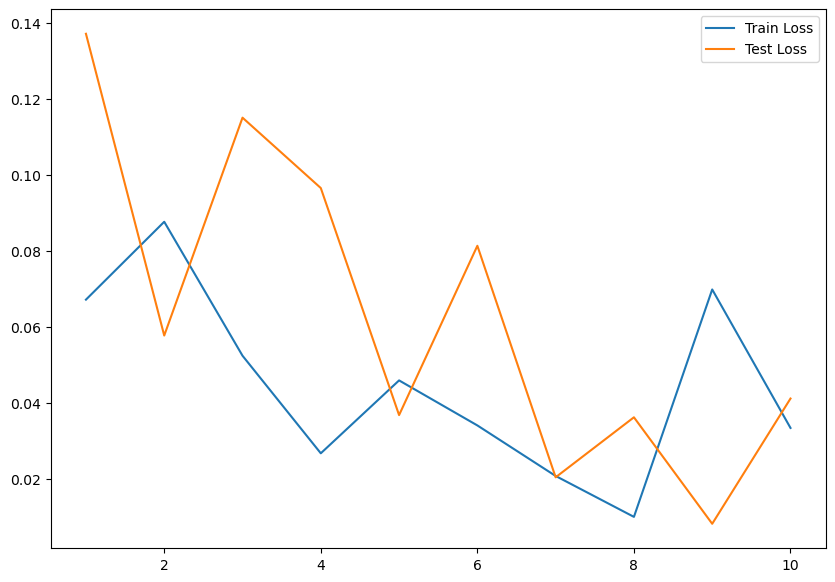

In [12]:
epochs = range(1, NUM_EPOCHS+1)
plt.figure(figsize=(10, 7))
plt.plot(epochs, loss_train_stat)
plt.plot(epochs, loss_test_stat)
plt.legend(["Train Loss", "Test Loss"])
plt.show()

[0.96875, 0.96875, 0.984375, 0.984375, 0.984375, 0.9921875, 0.9921875, 1.0, 0.984375, 0.9921875]


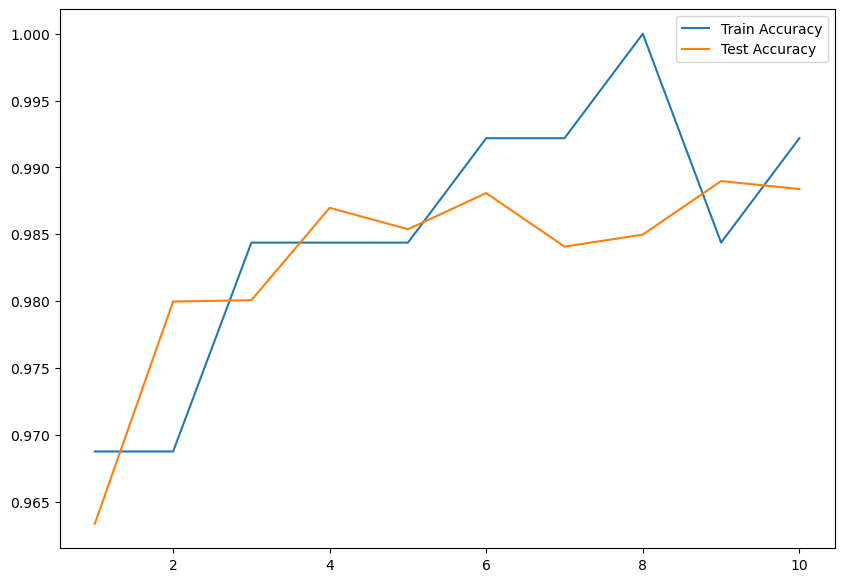

In [13]:
epochs = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(10, 7))
print(accuracy_train_stat)
plt.plot(epochs, accuracy_train_stat)
plt.plot(epochs, accuracy_test_stat)
plt.legend(["Train Accuracy", "Test Accuracy"])
plt.show()

In [14]:
import cv2
import numpy as np

data = []
classes = [2, 3, 6, 8, 9, 1, 0, 4, 7, 5]
for i in range(10):
    img = cv2.imread("../my_dataset/"+str(i+1)+".png")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    sharp_filter = np.array([[-1, 0, -1],
                             [ 0, 7,  0],
                             [-1, 0, -1]])
    img = cv2.filter2D(img, ddepth=-1, kernel=sharp_filter)

    img = cv2.bitwise_not(img)
    img = img.astype('float32')
    data.append(img)

data = np.reshape(data,(len(data), 1, 28, 28))
# data = np.array(data)
classes = np.array(classes)

print(data.shape)

(10, 1, 28, 28)


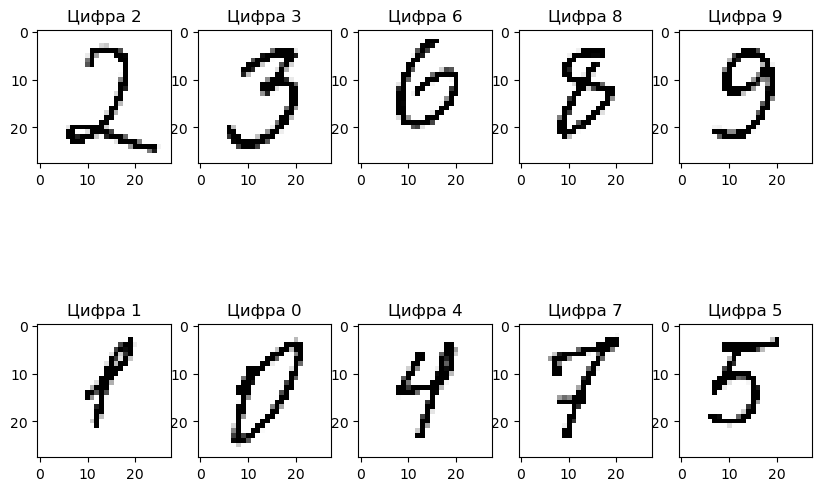

In [15]:
plt.figure(figsize=(10, 7))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(data[i].reshape(28, 28), cmap='Greys')
    plt.title("Цифра %d" % classes[i])

In [16]:
experiment_dataset = TensorDataset(torch.from_numpy(data).float(),
                                   torch.from_numpy(classes).long())
experiment_loader = DataLoader(experiment_dataset,
                          shuffle=False,
                          # pin_memory=True,
                          # num_workers=8,
                          # drop_last=True,

                          batch_size=BATCH_SIZE)

mnistnet.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in experiment_loader:
        outputs = mnistnet(images)
        predicted = torch.argmax(outputs, dim=1)
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()

    print("Test accuracy:",
        100 * correct / total, "%")


Test accuracy: 80.0 %


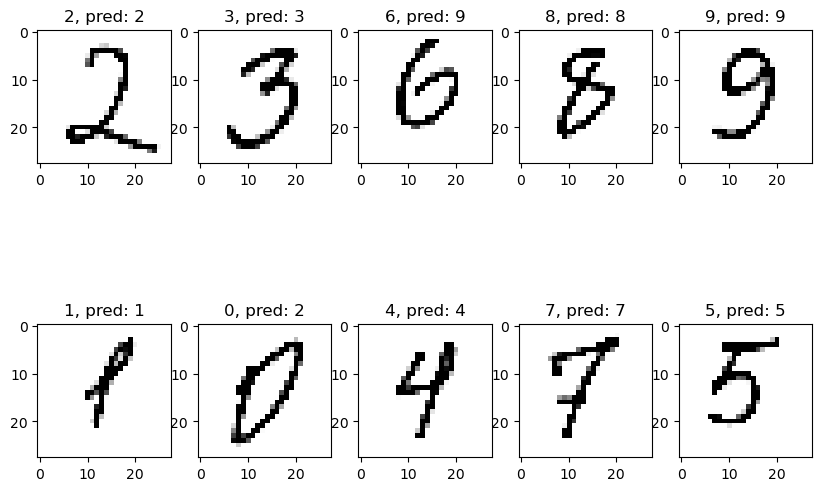

In [17]:
plt.figure(figsize=(10, 7))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(data[i].reshape(28, 28), cmap='Greys')
    plt.title("%d, pred: %d" % (classes[i], predicted[i]))

In [24]:
import random
X_test_pixel = []
y_test_pixel = y_test
for i, img in enumerate(X_test):
    x = int(7 + random.random() * 14)
    y = int(7 + random.random() * 14)
    print(img[0][y][x])

    if img[0][y][x] <= 127:
        img[0][y][x] = 0
    else:
        img[0][y][x] = 255


    X_test_pixel.append(img)

60.0
0.0
124.0
253.0
0.0
0.0
50.0
226.0
15.0
227.0
0.0
0.0
0.0
252.0
0.0
0.0
253.0
0.0
0.0
0.0
130.0
116.0
86.0
0.0
165.0
253.0
0.0
253.0
253.0
0.0
41.0
0.0
0.0
0.0
252.0
44.0
24.0
0.0
0.0
0.0
0.0
115.0
0.0
0.0
0.0
21.0
0.0
0.0
64.0
0.0
0.0
253.0
0.0
0.0
0.0
0.0
0.0
0.0
92.0
0.0
128.0
0.0
146.0
0.0
70.0
254.0
0.0
0.0
0.0
124.0
234.0
170.0
0.0
0.0
253.0
253.0
80.0
0.0
186.0
203.0
252.0
0.0
211.0
252.0
254.0
253.0
22.0
19.0
253.0
0.0
219.0
196.0
149.0
222.0
0.0
253.0
252.0
253.0
0.0
253.0
151.0
0.0
253.0
0.0
0.0
70.0
154.0
254.0
161.0
86.0
231.0
151.0
0.0
0.0
252.0
254.0
78.0
248.0
0.0
0.0
0.0
0.0
0.0
254.0
144.0
0.0
0.0
253.0
0.0
104.0
15.0
253.0
0.0
0.0
0.0
0.0
0.0
71.0
252.0
0.0
0.0
0.0
202.0
0.0
214.0
0.0
172.0
253.0
106.0
252.0
115.0
121.0
254.0
255.0
0.0
220.0
60.0
253.0
10.0
0.0
205.0
0.0
0.0
143.0
5.0
0.0
130.0
0.0
159.0
118.0
0.0
0.0
255.0
254.0
88.0
0.0
0.0
252.0
0.0
28.0
0.0
43.0
255.0
255.0
190.0
0.0
0.0
0.0
252.0
114.0
0.0
0.0
0.0
139.0
75.0
39.0
254.0
0.0
188.0
247.0
73.0
1

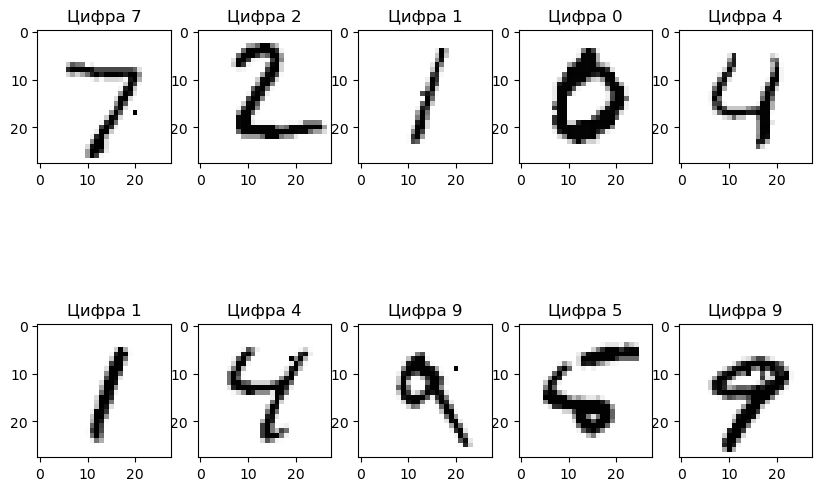

In [25]:
plt.figure(figsize=(10, 7))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test_pixel[i].reshape(28, 28), cmap='Greys')
    plt.title("Цифра %d" % y_test_pixel[i])

In [26]:
X_test_pixel = np.reshape(X_test_pixel,(len(X_test_pixel), 1, 28, 28))
# data = np.array(data)
y_test_pixel = np.array(y_test_pixel)

In [27]:
pixel_dataset = TensorDataset(torch.from_numpy(X_test_pixel).float(),
                             torch.from_numpy(y_test_pixel).long())
pixel_loader = DataLoader(pixel_dataset,
                          shuffle=False,
                          # pin_memory=True,
                          # num_workers=8,
                          # drop_last=True,
                          batch_size=BATCH_SIZE)

In [28]:
mnistnet.eval()
with torch.no_grad():
    correct = 0
    total = 0
    predict_results = []
    for images, labels in pixel_loader:
        outputs = mnistnet(images)
        predicted_pixel = torch.argmax(outputs, dim=1)
        predict_results+=predicted_pixel
        total += labels.shape[0]
        correct += (predicted_pixel == labels).sum().item()

    print("Test accuracy:",
        100 * correct / total, "%")

Test accuracy: 98.69 %


10000


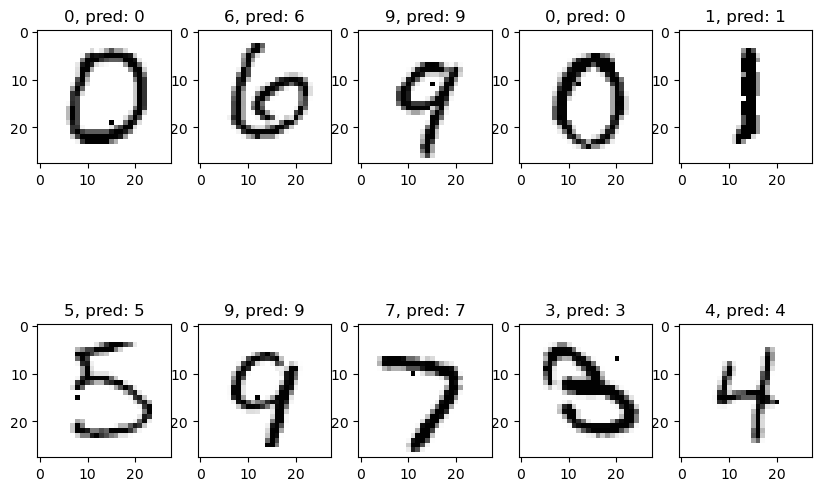

In [29]:
plt.figure(figsize=(10, 7))
print(len(predict_results))
for i in range(10, 20):
    plt.subplot(2, 5, i-9)
    plt.imshow(X_test_pixel[i].reshape(28, 28), cmap='Greys')
    plt.title("%d, pred: %d" % (y_test_pixel[i], predict_results[i]))